*This notebook develops the architecture for training a VAE on the T1-weighted MRI. VAEs are also trained on the T2-weighted MRI and tumour masks*


### 1. [set up the DataLoaders](#scrollTo=tzeP6Md6D9R2)
Read in `t1_arraysstan_32.pkl`, `t2_arraysstan_32.pkl`, `mask_arrayscropped_8.pkl` (see <b>VAE_processing.ipynb</b>) Set up the train and test loaders using these data structures. 

### 2. [Specify the VAE architecture for T1-weighted MRI](#scrollTo=CP0DWrUAFBGx&line=1&uniqifier=1)

The first architecture is based on [this website](https://keras.io/examples/generative/vae/), which uses a fully-connected layer to map to the latent space. 

What we adopt, is using a convolutional layer to map to the latent space. [According to this paper](https://arxiv.org/abs/1806.05452) this helps to retain spatial information throughout the autoencoder. The reconstructions are also much more realistic. 

We also provide some results from training the VAE. 

### 3. [Generate new images using the trained VAE](#scrollTo=nQvrrQlzESx8&line=1&uniqifier=1)

For a given batch of images,

1. Use the encoder to get their corresponding points in latent space

2. Perturb the points using some error, e.g. $\epsilon \sim N(0,1)$

3. Use the decoder to reconstruct the perturbed points

-----

I also run the [VAE on T2](#scrollTo=XK_L9BKp5wpX) and on the [Tumor masks](#scrollTo=RrzdFj8-QoZV&line=1&uniqifier=1)

The VAE on T2 uses exactly the same architecture as the one on T1. 

For the VAE on masks, we played around with a few architectures and losses, and provide the best architecture below. Note that: 

- the loss for training the mask VAE is DICE
- Since masks are binary {0: healthy tissue, 1: tumor} we append a sigmoid activation layer at the end of the decoder, to map its output to [0,1]




In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#no need to use GPU yet, since not using any GPU-accelerated libraries: 
#https://stackoverflow.com/questions/61360422/anyone-experienced-the-warning-about-google-colaboratoryyou-are-connected-to-a

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
#https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install platipy
# import SimpleITK as sitk
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import seaborn as sns
import pandas as pd

import torchvision
from torch.utils.data import Dataset

In [4]:
#download final output from Section 2 of ISPY_processing.ipynb
import gdown 

gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo","t1_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_","t2_arraysstan_32.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7","mask_arrayscropped_8.pkl")
gdown.download(f"https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC","patient_labels.pkl") #need patient labels for pytorch train/test split later

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=18UiIIxQF8jtIZWYI3pkEaoAhZjDkLgmo
To: /content/t1_arraysstan_32.pkl
100%|██████████| 981M/981M [00:07<00:00, 133MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1--LgF7Ka9LiPvl6ANbDPHKpwO-4F__Y_
To: /content/t2_arraysstan_32.pkl
100%|██████████| 981M/981M [00:08<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-19CAZ8k1gWVaNCNbjbZfJz5ZJERFjx7
To: /content/mask_arrayscropped_8.pkl
100%|██████████| 245M/245M [00:01<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1A8Ghp8bJExZenndd7P43t9GE0JuX41iC
To: /content/patient_labels.pkl
100%|██████████| 4.85k/4.85k [00:00<00:00, 11.0MB/s]


'patient_labels.pkl'

In [5]:
!ls 

drive			  patient_labels.pkl  t1_arraysstan_32.pkl
mask_arrayscropped_8.pkl  sample_data	      t2_arraysstan_32.pkl


In [7]:
import pickle

#load the files into namespace
with open('/content/t1_arraysstan_32.pkl', 'rb') as f: 
    t1_arrays = pickle.load(f)

with open('/content/t2_arraysstan_32.pkl', 'rb') as f: 
    t2_arrays = pickle.load(f)

with open('/content/mask_arrayscropped_8.pkl', 'rb') as f: 
    mask_arrays = pickle.load(f)

with open('/content/patient_labels.pkl', 'rb') as f:
    patient_labels = pickle.load(f)

## prepare data for loading

In [ ]:
import pickle 
#save
# with open('/content/drive/MyDrive/Colab Notebooks/t1_arrays.pkl', 'wb') as f:
#     pickle.dump(t1_arrays, f)

# with open('/content/drive/MyDrive/Colab Notebooks/t2_arrays.pkl', 'wb') as f:
#     pickle.dump(t2_arrays, f)

# with open('/content/drive/MyDrive/Colab Notebooks/mask_arrays.pkl', 'wb') as f:
#     pickle.dump(mask_arrays, f)

#open
 #minmax: t1_arrays_mm32, standardised using the box: t1_arraysV2_32

# standardised cropped images: t1_arraysstan_32.pkl

# with open('/content/drive/MyDrive/Colab Notebooks/t1_arraysstan_32.pkl', 'rb') as f: #minmax [-1,1]: t1_arraysmm_32
#     t1_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/t2_arraysstan_32.pkl', 'rb') as f:
#     t2_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/mask_arrayscropped_8.pkl', 'rb') as f:
#     mask_arrays = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/patient_labels.pkl', 'rb') as f:
#     patient_labels = pickle.load(f)

In [8]:
def show_slice(t1, t2, mask):
  #args are ndarrays
  fig, ax = plt.subplots(nrows=1, ncols = 3,
                         figsize=(10,5), sharey = True)
  fig.tight_layout()

  ax[0].set_title("T1"); ax[0].imshow(t1)
  ax[1].set_title("T2"); ax[1].imshow(t2)
  ax[2].set_title("mask"); ax[2].imshow(mask)

1413
761
496
897
151
819
397
1421
398
920


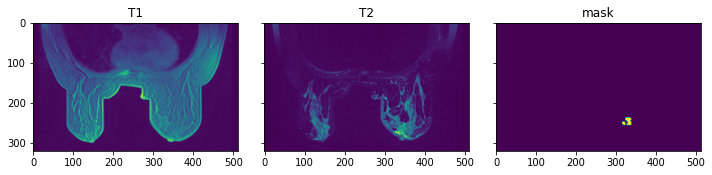

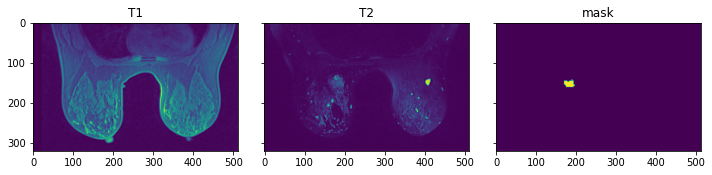

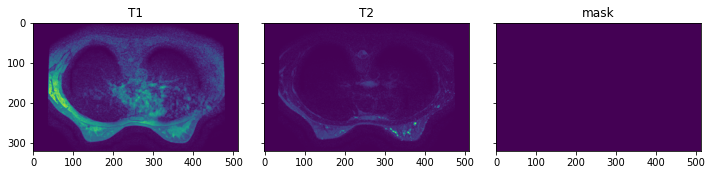

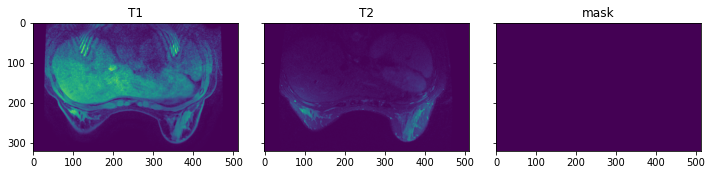

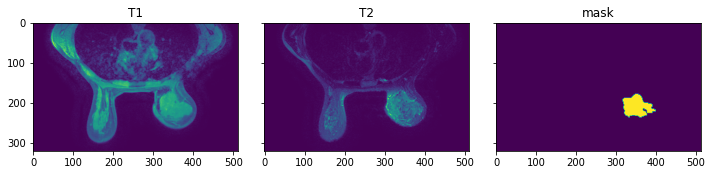

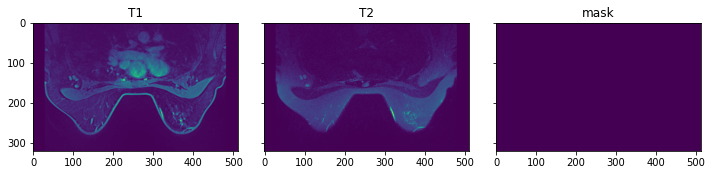

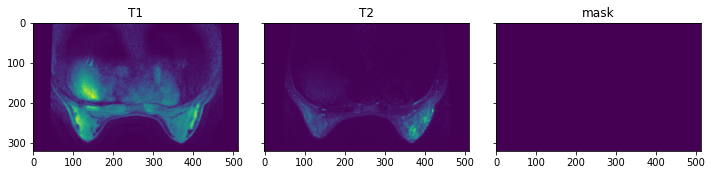

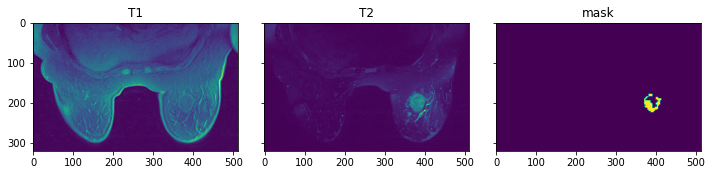

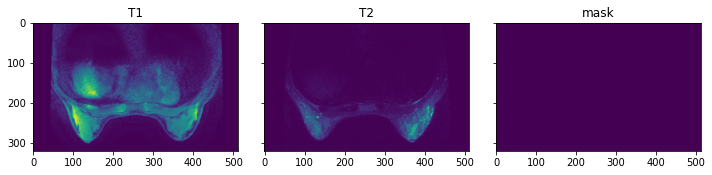

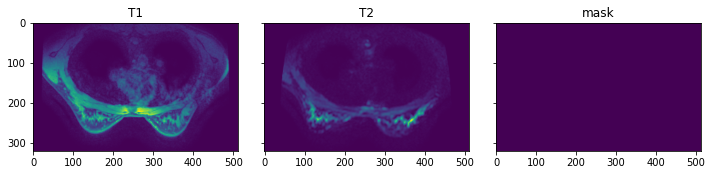

In [ ]:
## check some random patients
import random

for idx in random.sample(range(t1_arrays.shape[0]), 10):
  print(idx)
  show_slice(t1_arrays[idx], t2_arrays[idx], mask_arrays[idx])

In [ ]:
print(t1_arrays.dtype, t2_arrays.dtype, mask_arrays.dtype)
t1_arrays.shape

float32 float32 int8


(1497, 320, 512)

In [ ]:
print(patient_labels[:21])

['ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-102212', 'ACRIN-6698-103939']


### set up DataLoader

In [9]:
train_prop = 0.8 #take 0.8 of patients for training, the rest for test

import random; random.seed(4) 
unique_p = list(dict.fromkeys(patient_labels)) #preserve order of patients
train_p = random.sample(unique_p, 
                        int(train_prop*len(unique_p)))
print(len(train_p))

train_indexes = [e in train_p for e in patient_labels]
print("train prop:", sum(train_indexes)/len(train_indexes),
      "train size:", sum(train_indexes)) #0.8 of the data for training

81
train prop: 0.8102872411489646 train size: 1213


In [10]:
def get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes):
  z_dim = len(train_indexes)
  test_indexes = [not e for e in train_indexes]
  return t1_arrays[train_indexes], t2_arrays[train_indexes], mask_arrays[train_indexes], t1_arrays[test_indexes], t2_arrays[test_indexes], mask_arrays[test_indexes]


train_t1, train_t2, train_mask, test_t1, test_t2, test_mask = get_train_slices(t1_arrays, t2_arrays, mask_arrays, train_indexes) #split the slices into train and test
print(train_t1.shape)
print(test_t1.shape)

(1213, 320, 512)
(284, 320, 512)


In [11]:
class ISPY_dataset(Dataset):

  def __init__(self, t1_arrays, t2_arrays, mask_arrays,
                     transforms):
    self.t1_arrays = t1_arrays
    self.t2_arrays = t2_arrays
    self.mask_arrays = mask_arrays
    self.transforms = transforms

  def __len__(self):
    return self.t1_arrays.shape[0]

  def __getitem__(self, idx):
    t1 = t1_arrays[idx]; t2 = t2_arrays[idx]; mask = mask_arrays[idx]

    ##transform the T1 and T2
    if self.transforms is not None: 
      t1 = self.transforms(t1)
      t2 = self.transforms(t2)
      mask = self.transforms(mask)

    return (t1, t2, mask)

In [12]:
# define transformations for T1 and T2
my_transforms = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((128, 128))
  ])

train_data = ISPY_dataset(train_t1, train_t2, train_mask, 
                          my_transforms)

test_data = ISPY_dataset(test_t1, test_t2, test_mask, 
                          my_transforms)

print(len(train_data))
print(len(test_data))

1213
284


In [13]:
torch.set_printoptions(edgeitems=3)
print(train_data[0]) # t1, t2 and mask
print(train_data[0][0].shape) #each image has 1 channel, and is 128 x 128

(tensor([[[-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         [-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         [-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         ...,
         [-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         [-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590],
         [-0.7590, -0.7590, -0.7590,  ..., -0.7590, -0.7590, -0.7590]]]), tensor([[[-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         ...,
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449],
         [-0.5449, -0.5449, -0.5449,  ..., -0.5449, -0.5449, -0.5449]]]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
        

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 128, shuffle=True);
test_loader = DataLoader(test_data, batch_size = 128, shuffle=True)

In [15]:
torch.manual_seed(3)
t1, t2, mask = next(iter(train_loader))
print(t1.shape)

torch.Size([128, 1, 128, 128])


In [16]:
# for i in range(20):
#   t1_img = t1[i,:,:,:][0].numpy()
#   plt.imshow(t1_img); plt.show()

#pick the seventh T1

#take an image just to track reconstructions later
t1_img = torch.index_select(t1, dim = 0, index = torch.tensor([6]))
t1_img.shape

torch.Size([1, 1, 128, 128])

## VAE on T1

In [17]:
import torch; torch.manual_seed(2)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)
!pip install torchinfo

device: cpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Simple VAE using MNIST architecture (FIRST VERSION. DON'T RUN)

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        self.linear1 = nn.Linear(16*8*8, 512)
        
        self.linear2 = nn.Linear(512, latent_dims) #vector of means
        self.linear3 = nn.Linear(512, latent_dims) #vector of sds

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

        x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.linear1(x))

        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x)) #exponential activation to ensure positive
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
        return z

In [ ]:
from torchinfo import summary

summary(VariationalEncoder(16), input_size= t1.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalEncoder                       [128, 16]                 --
├─Conv2d: 1-1                            [128, 8, 64, 64]          80
├─BatchNorm2d: 1-2                       [128, 8, 64, 64]          16
├─MaxPool2d: 1-3                         [128, 8, 32, 32]          --
├─Conv2d: 1-4                            [128, 16, 16, 16]         1,168
├─BatchNorm2d: 1-5                       [128, 16, 16, 16]         32
├─MaxPool2d: 1-6                         [128, 16, 8, 8]           --
├─Linear: 1-7                            [128, 512]                524,800
├─Linear: 1-8                            [128, 16]                 8,208
├─Linear: 1-9                            [128, 16]                 8,208
Total params: 542,512
Trainable params: 542,512
Non-trainable params: 0
Total mult-adds (M): 149.50
Input size (MB): 8.39
Forward/backward pass size (MB): 76.05
Params size (MB): 2.17
Estimated Total Size (MB): 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 16*8*8)

        self.convt1 = nn.ConvTranspose2d(16, 8, kernel_size = 7, padding = 2, stride = 4, output_padding = 2)
        self.bn1 = nn.BatchNorm2d(8)

        self.convt2 = nn.ConvTranspose2d(8, 1, kernel_size = 6, padding = 3, stride = 4) #undo the maxpool and conv
        self.bn2 = nn.BatchNorm2d(1)


    def forward(self, z):
        z = F.leaky_relu(self.linear1(z))
        z = F.leaky_relu(self.linear2(z))
        z = z.reshape((-1, 16, 8, 8))

        z = F.leaky_relu(self.bn1(self.convt1(z)))
        z = self.bn2(self.convt2(z))
        x = torch.tanh(z)
        return x

In [ ]:
summary(Decoder(8), input_size= (128,8))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 1, 128, 128]        --
├─Linear: 1-1                            [128, 512]                4,608
├─Linear: 1-2                            [128, 1024]               525,312
├─ConvTranspose2d: 1-3                   [128, 8, 33, 33]          6,280
├─BatchNorm2d: 1-4                       [128, 8, 33, 33]          16
├─ConvTranspose2d: 1-5                   [128, 1, 128, 128]        289
├─BatchNorm2d: 1-6                       [128, 1, 128, 128]        2
Total params: 536,507
Trainable params: 536,507
Non-trainable params: 0
Total mult-adds (G): 1.55
Input size (MB): 0.00
Forward/backward pass size (MB): 52.97
Params size (MB): 2.15
Estimated Total Size (MB): 55.12

In [ ]:
#change out the Encoder for Variational Encoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Improvement: convolutional map to latent space

- use convolutional map to latent space
- don't use activation function at the end, so that the model learns how to map values to real line (i.e. the range of values taken by the actual images)

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels, while downsampling the image. This way, information isn't lost
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        #mean and stds
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv4 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

        x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

        mu =  self.conv3(x)
        sigma = torch.exp(self.conv4(x)) #exponential activation to ensure positive
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
        return z

In [ ]:
from torchinfo import summary

summary(VariationalEncoder(), input_size= t1.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalEncoder                       [128, 32, 4, 4]           --
├─Conv2d: 1-1                            [128, 8, 64, 64]          80
├─BatchNorm2d: 1-2                       [128, 8, 64, 64]          16
├─MaxPool2d: 1-3                         [128, 8, 32, 32]          --
├─Conv2d: 1-4                            [128, 16, 16, 16]         1,168
├─BatchNorm2d: 1-5                       [128, 16, 16, 16]         32
├─MaxPool2d: 1-6                         [128, 16, 8, 8]           --
├─Conv2d: 1-7                            [128, 32, 4, 4]           4,640
├─Conv2d: 1-8                            [128, 32, 4, 4]           4,640
Total params: 10,576
Trainable params: 10,576
Non-trainable params: 0
Total mult-adds (M): 99.23
Input size (MB): 8.39
Forward/backward pass size (MB): 76.55
Params size (MB): 0.04
Estimated Total Size (MB): 84.98

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 5,  stride = 4, padding = 1, output_padding = 1) #undo the maxpool and conv
        self.bn3 = nn.BatchNorm2d(1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))
        
        z = self.bn3(self.convt3(z))
        
       
        x = z 
        #new idea: drop the activation entirely! https://qr.ae/pr5s0Y
        return x

In [ ]:
summary(Decoder(), input_size= (128,32,4,4))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 1, 128, 128]        --
├─ConvTranspose2d: 1-1                   [128, 16, 8, 8]           4,624
├─BatchNorm2d: 1-2                       [128, 16, 8, 8]           32
├─ConvTranspose2d: 1-3                   [128, 8, 32, 32]          3,208
├─BatchNorm2d: 1-4                       [128, 8, 32, 32]          16
├─ConvTranspose2d: 1-5                   [128, 1, 128, 128]        201
├─BatchNorm2d: 1-6                       [128, 1, 128, 128]        2
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0
Total mult-adds (M): 879.89
Input size (MB): 0.26
Forward/backward pass size (MB): 52.43
Params size (MB): 0.03
Estimated Total Size (MB): 52.72

In [ ]:
#change out the Encoder for Variational Encoder
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

### Train

In [ ]:
def validate_one_epoch(autoencoder, loader, recon_loss_fn):
    #validate results on the validation loader
    
    autoencoder.eval()# Set model to evaluation mode
    num_samples = len(loader.dataset) 
    
    # Initialise metrics
    mse = 0.0
    kl = 0.0
    
    latent_dim = None
    for i, (t1, t2, mask) in enumerate(loader):

        # Move data to GPU, if available
        t1 = t1.to(device); t2 = t2.to(device); mask = mask.to(device)

        with torch.no_grad():  # sure that we will not backpropagate
            
            if latent_dim is None:
              latent_dim = torch.tensor(autoencoder.encoder(t1).shape)
              
            # Prediction
            t1_hat = autoencoder(t1) #(128, 1, 256, 256) predictions for one batch

            mse += recon_loss_fn(t1_hat, t1)*(t1.shape[0]/num_samples) #e.g MSE takes the mean already. weight this by the size of the batch
            
            kl += autoencoder.encoder.kl.sum()/t1.shape[0] #sum over [128, 128,   5,   5], then divide by batch size. i.e. average TOTAL kl per image

    kl = kl/(torch.prod(latent_dim[1:]).item()) #then average the kl divergence by size of the latent space
    return mse, kl

In [ ]:
#early stopper https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            print("validation didn't improve")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
#train over epochs of the training set

def train(autoencoder, data, valid_data, epochs=3, lr = 0.003, recon_loss_fn = F.mse_loss, pic_tensor = t1_img):
    early_stopper = EarlyStopper(patience=3, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(autoencoder.parameters(), lr) #default lr = 0.001

    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0

    image_progress = [autoencoder(pic_tensor)]

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t1, t2, mask) in enumerate(data):
            t1 = t1.to(device) # GPU
           
            opt.zero_grad()
            t1_hat = autoencoder(t1) #just t1 for now. #(128, 1, 256, 256) for one batch
            reconstruction = recon_loss_fn(t1, t1_hat)
            kl = autoencoder.encoder.kl.mean()
            loss = reconstruction + kl 
            #if custom loss fn, loss_fn(x_hat, x)
            
            print("batch {} loss: {:.5} MSE {:.4}, KL {:.4}".format(i, loss.item(), reconstruction, kl.item()))

            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t1.shape[0]/num_samples)

      valid_mse, valid_kl = validate_one_epoch(autoencoder, valid_data, recon_loss_fn)
      print("validation loss {:.5} MSE {:.4} KL {:.4}\n".format(valid_mse + valid_kl, valid_mse, valid_kl) )

      autoencoder.eval()

      with torch.no_grad():
        image_progress.append(autoencoder(pic_tensor))

      table.iloc[epoch, 1] = np.round(train_loss, 3)
      table.iloc[epoch, 2] = np.round((valid_mse + valid_kl).item(), 3)

      # if early_stopper.early_stop(valid_mse + valid_kl):             
      #   break
            
    return autoencoder, table, image_progress


torch.manual_seed(4) 
# vae = VariationalAutoencoder(latent_dims = 16).to(device) # train simplest version
vae = VariationalAutoencoder().to(device) 
vae, table, image_progress = train(vae, train_loader, test_loader, epochs = 60, lr = 0.002, recon_loss_fn = F.mse_loss) 

epoch: 0
batch 0 loss: 5.9052 MSE 2.023, KL 3.883
batch 1 loss: 3.7244 MSE 1.984, KL 1.74
batch 2 loss: 3.0474 MSE 1.952, KL 1.095
batch 3 loss: 2.7505 MSE 1.925, KL 0.8251
batch 4 loss: 2.6274 MSE 1.903, KL 0.7243
batch 5 loss: 2.541 MSE 1.88, KL 0.6611
batch 6 loss: 2.473 MSE 1.841, KL 0.6322
batch 7 loss: 2.3928 MSE 1.782, KL 0.6109
batch 8 loss: 2.3227 MSE 1.725, KL 0.5974
batch 9 loss: 2.2518 MSE 1.654, KL 0.5981
validation loss 2.4283 MSE 0.9743 KL 1.454

epoch: 1
batch 0 loss: 1.4608 MSE 0.9736, KL 0.4872
batch 1 loss: 1.4517 MSE 0.9676, KL 0.4841
batch 2 loss: 1.4414 MSE 0.9614, KL 0.4801
batch 3 loss: 1.4285 MSE 0.9591, KL 0.4694
batch 4 loss: 1.4148 MSE 0.9553, KL 0.4595
batch 5 loss: 1.399 MSE 0.9536, KL 0.4454
batch 6 loss: 1.3918 MSE 0.9532, KL 0.4386
batch 7 loss: 1.3852 MSE 0.9507, KL 0.4345
batch 8 loss: 1.3735 MSE 0.9476, KL 0.426
batch 9 loss: 1.3657 MSE 0.9468, KL 0.4189
validation loss 2.1823 MSE 0.9458 KL 1.236

epoch: 2
batch 0 loss: 1.3597 MSE 0.9468, KL 0.4129
b

### visualise results

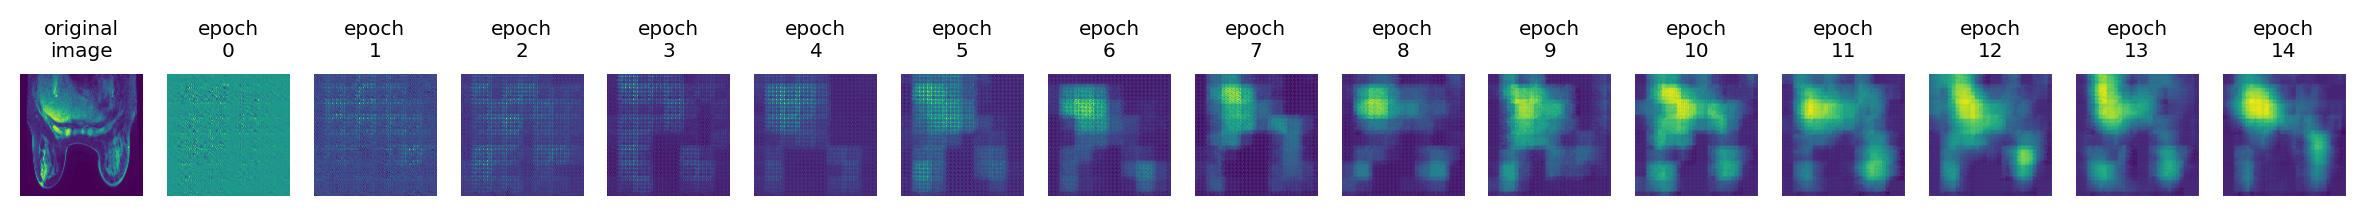

In [ ]:
images_np = [t.detach()[0][0].numpy() for t in image_progress[:15]] #take till the 15th


plt.rcParams.update({'font.size': 6})
fig, axes = plt.subplots(ncols = len(images_np) + 1, figsize = (15,15))

axes[0].imshow(t1_img.detach()[0][0].numpy())
axes[0].axis('off')
axes[0].set_title("original\nimage")

for i in range(len(images_np)):
  axes[i+1].imshow(images_np[i])
  axes[i+1].axis('off')
  axes[i+1].set_title("epoch\n{}".format(i))


In [ ]:
table

epoch  train loss  valid loss
0       1       3.045       2.428
1       2       1.414       2.182
2       3       1.333       2.086
3       4       1.268       2.037
4       5       1.184       1.961
5       6       1.092       1.915
6       7       1.030       1.869
7       8       0.992       1.849
8       9       0.969       1.836
9      10       0.956       1.834
10     11       0.943       1.819
11     12       0.936       1.818
12     13       0.929       1.806
13     14       0.922       1.806
14     15       0.915       1.809
15     16       0.909       1.795
16     17       0.902       1.791
17     18       0.897       1.784
18     19       0.891       1.784
19     20       0.885       1.780
20     21       0.878       1.768
21     22       0.869       1.756
22     23       0.862       1.735
23     24       0.856       1.739
24     25       0.848       1.722
25     26       0.842       1.724
26     27       0.838       1.711
27     28       0.834       1.716
28     29       0.831       1.703
29     30       0.828       1.700
30     31       0.826       1.704
31     32       0.824       1.697
32     33       0.822       1.693
33     34       0.820       1.699
34     35       0.818       1.694
35     36       0.817       1.693
36     37       0.815       1.691
37     38       0.815       1.694
38     39       0.813       1.688
39     40       0.812       1.696
40     41       0.811       1.685
41     42       0.810       1.684
42     43       0.809       1.690
43     44       0.807       1.684
44     45       0.806       1.686
45     46       0.806       1.678
46     47       0.805       1.684
47     48       0.804       1.682
48     49       0.803       1.683
49     50       0.802       1.677
50     51       0.803       1.679
51     52       0.802       1.678
52     53       0.801       1.678
53     54       0.801       1.677
54     55       0.800       1.674
55     56       0.799       1.678
56     57       0.799       1.680
57     58       0.798       1.684
58     59       0.798       1.680
59     60       0.798       1.680

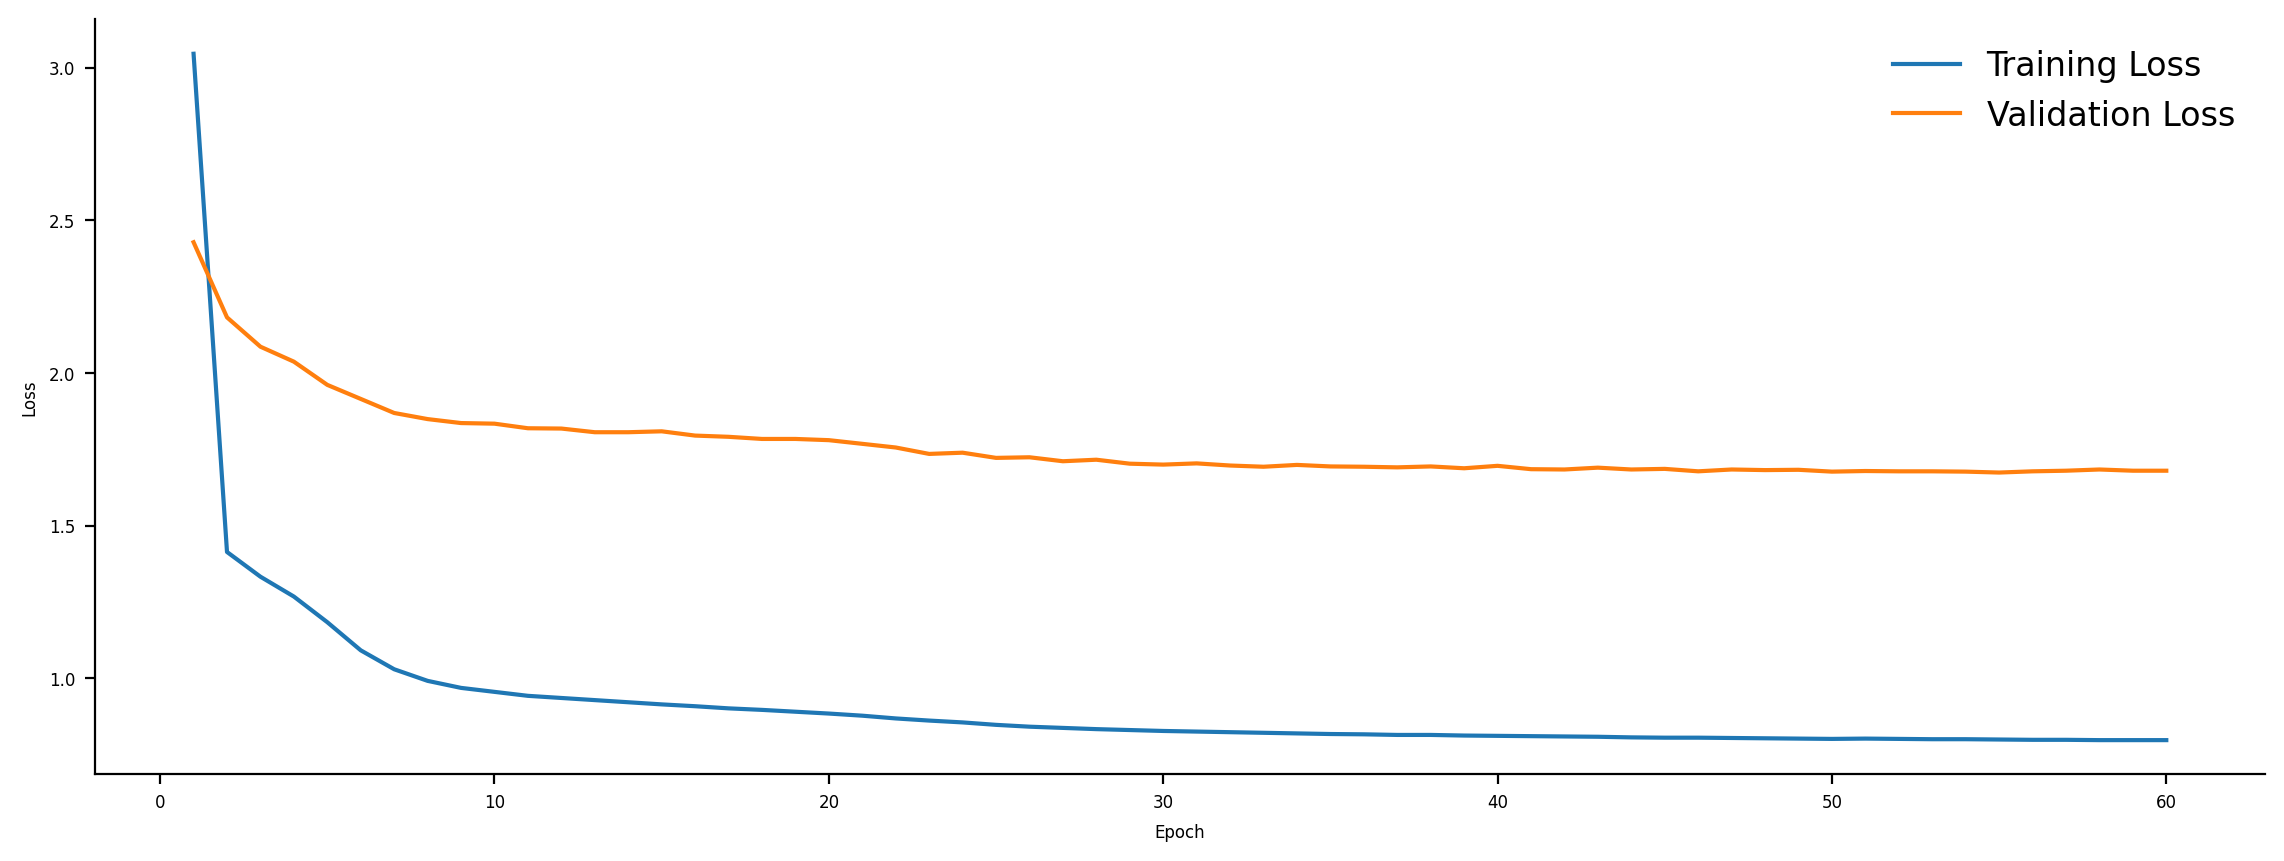

In [ ]:
fig , axes = plt.subplots(1, 1, figsize=(14, 5))


axes.plot(table['epoch'], table['train loss'], label = 'Training Loss')
axes.plot(table['epoch'], table['valid loss'], label = 'Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend(fontsize=12, frameon=False)

sns.despine()
plt.show()

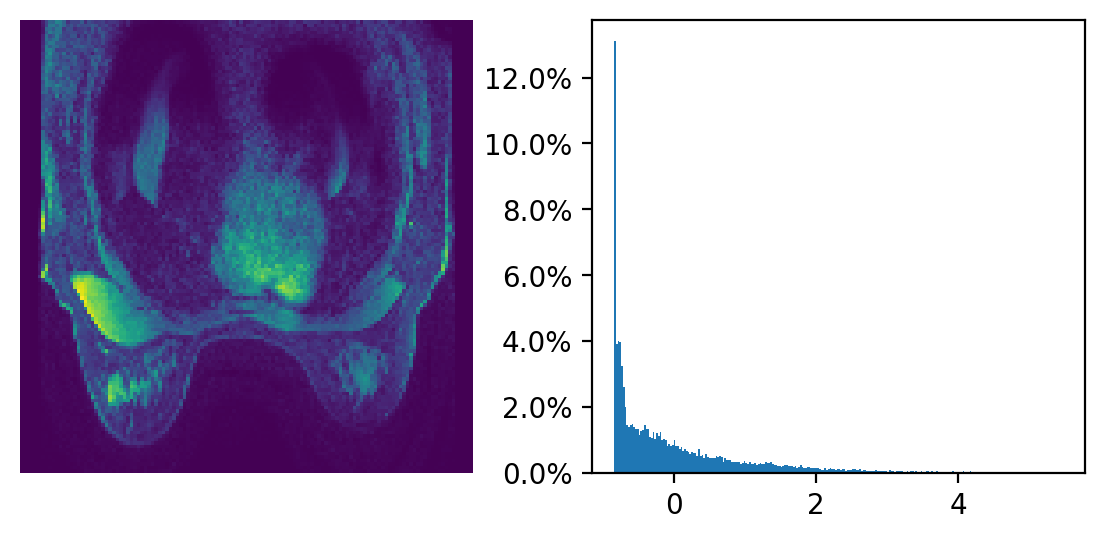

In [ ]:
import matplotlib.ticker 
from matplotlib.ticker import PercentFormatter

def plot_hist(img, vmin = None, vmax = None):
  #img is 512x512 nda
  fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (7,3))
  if vmin is None and vmax is None: 
    ax1.imshow(img); ax1.axis("off")

  else:
    ax1.imshow(img, vmin = vmin, vmax = vmax); ax1.axis("off")

  intensities = img.ravel()
  ax2.hist(intensities, weights=np.ones(len(intensities)) / len(intensities), bins = 256)
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plot_hist(t1[0][0]) #intensity histogram of T1 image

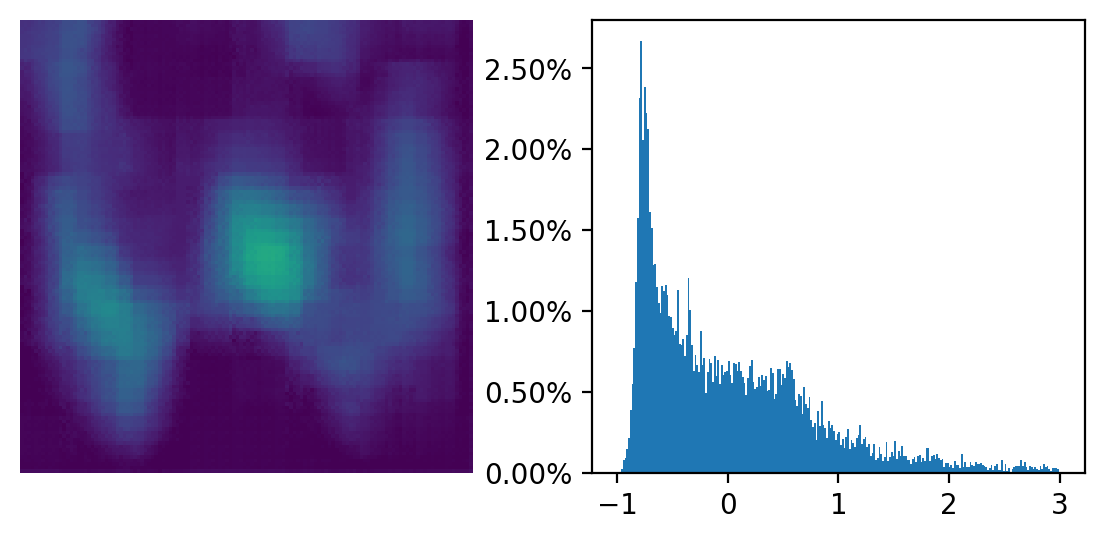

In [ ]:
plot_hist(reconstructions[0][0].detach().numpy(), 
          vmin = torch.min(t1[0][0]), 
          vmax = torch.max(t1[0][0]))
# intensity histogram of its reconstruction

## visualise results

In [ ]:
torch.manual_seed(3)
(t1, t2, mask)= next(iter(test_loader)) #get one batch
t1 = t1.to(device)
reconstructions = vae(t1)

In [ ]:
plt.rcParams.update({'font.size': 8})

def show_subplot(original, reconstructed):
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 2, 1); plt.title("Test set"); plt.axis("off")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2); plt.title("Reconstructed"); plt.axis("off")
    plt.imshow(reconstructed.detach(), vmin = torch.min(original), vmax = torch.max(original))
    
    plt.show()

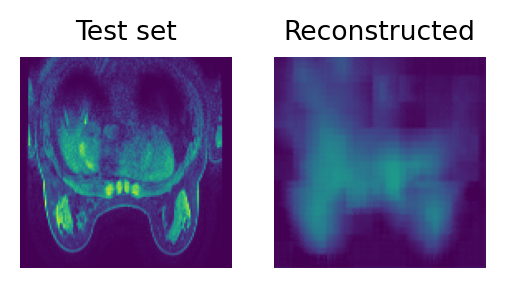

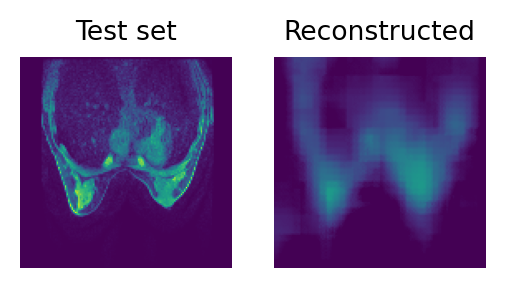

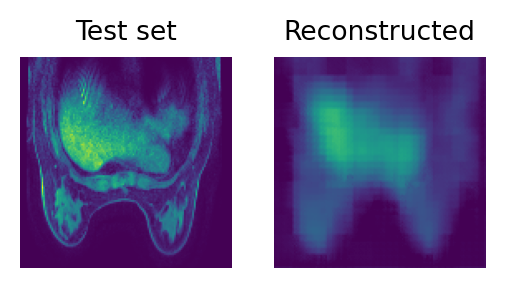

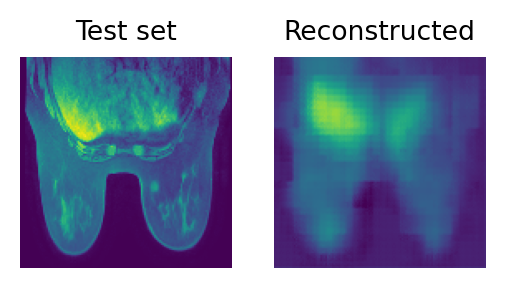

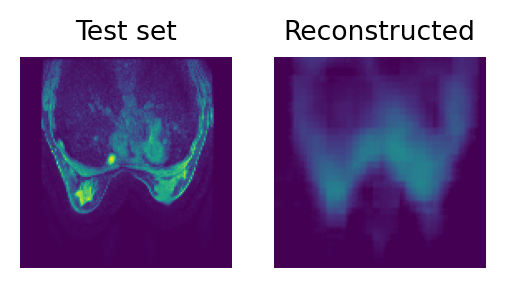

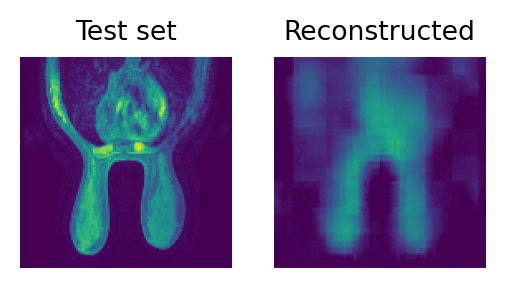

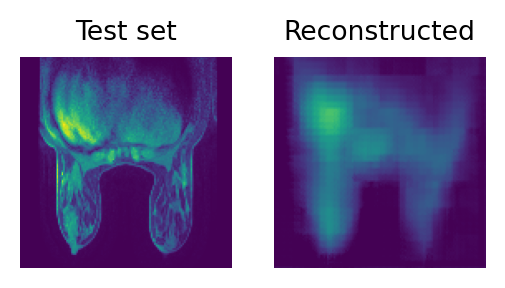

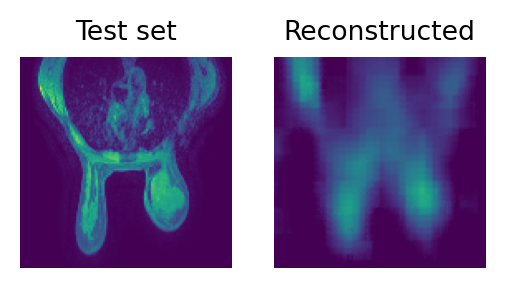

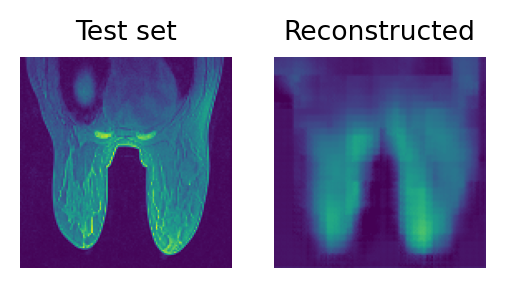

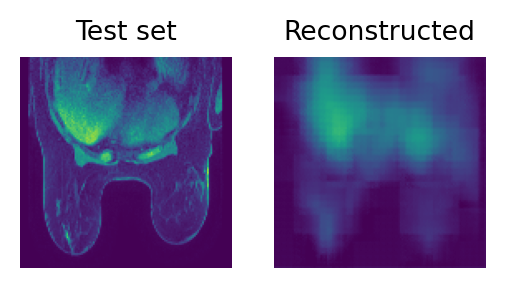

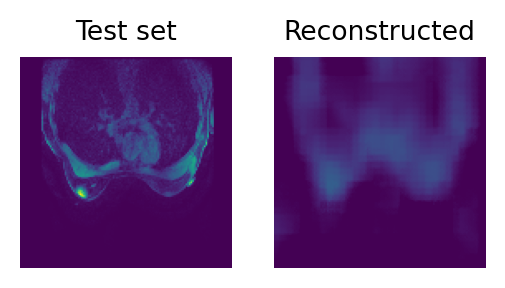

In [ ]:
#OURS: L2 loss, normalised data, NO FINAL ACTIVATION FUNCTION. convolutional map to latent space
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25]

images = [t1[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

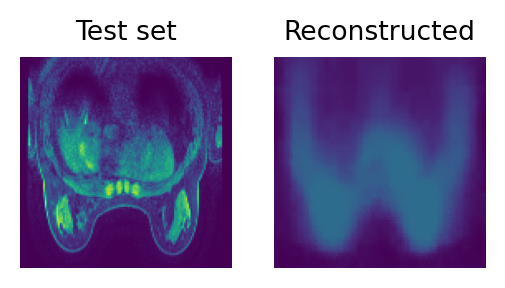

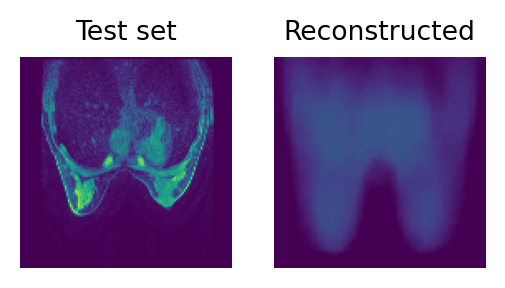

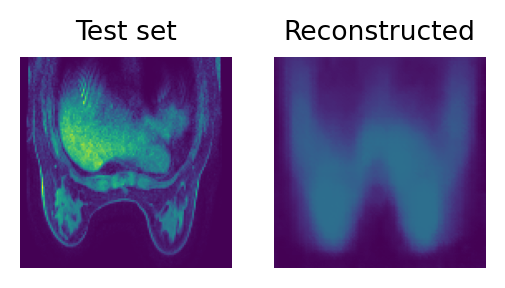

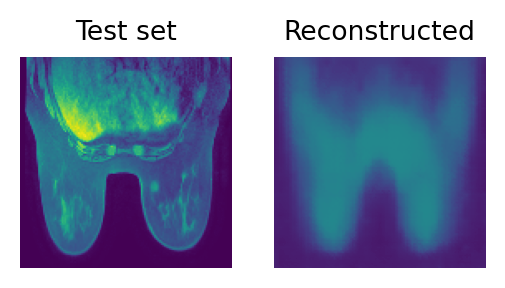

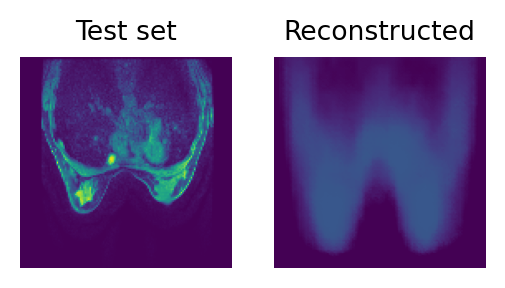

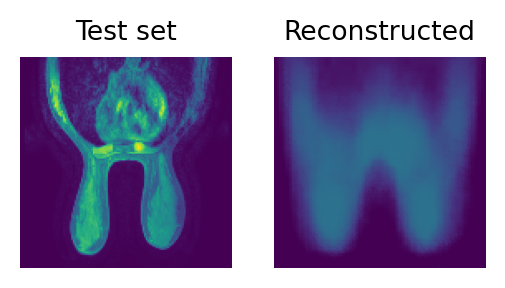

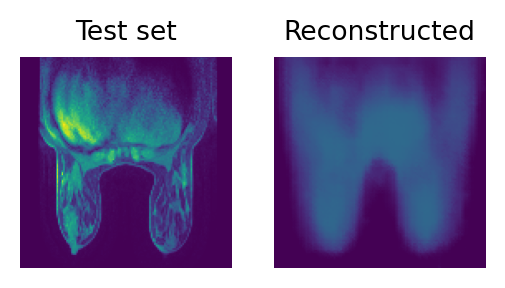

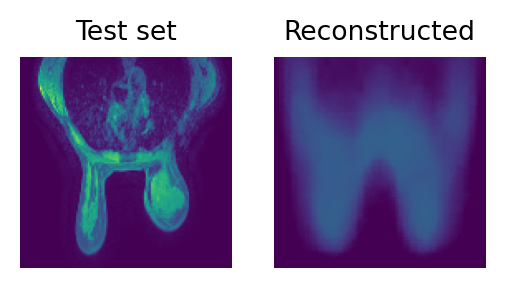

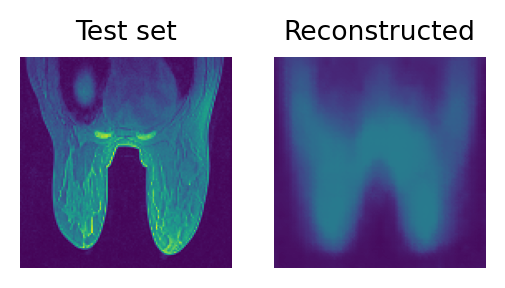

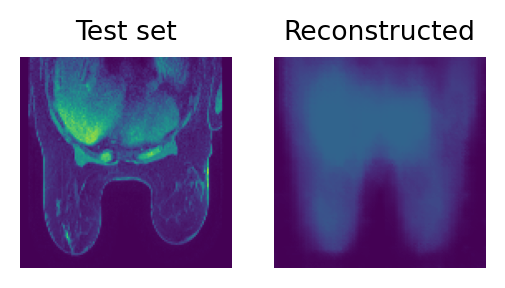

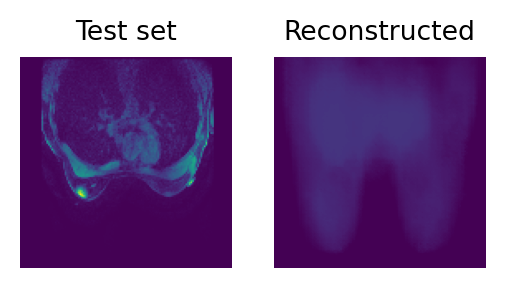

In [ ]:
#fully connected map to latent space
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25]

images = [t1[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

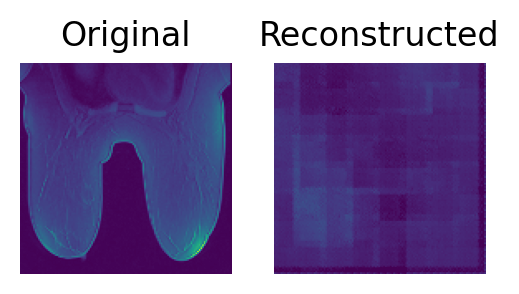

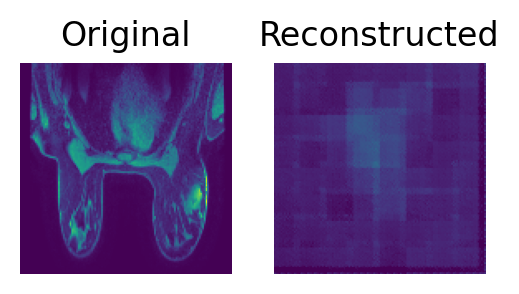

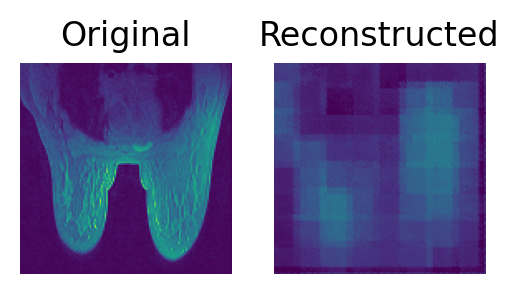

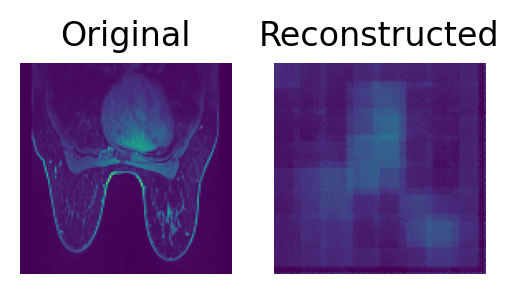

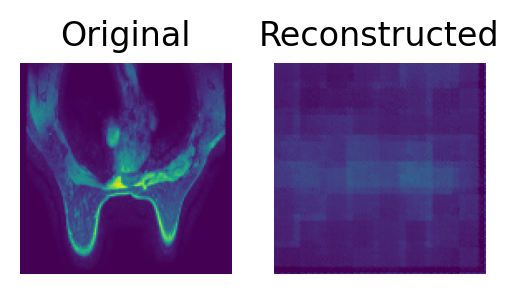

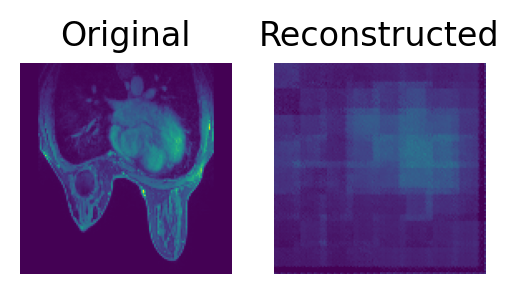

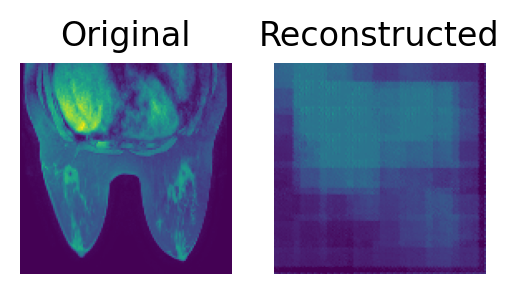

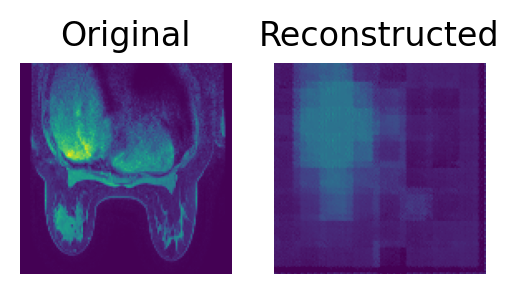

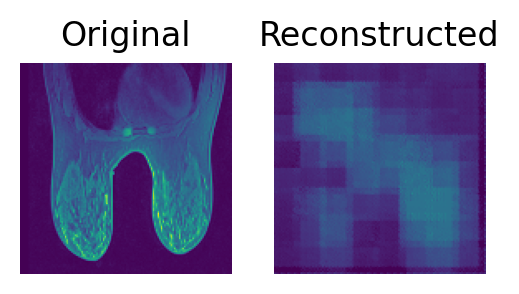

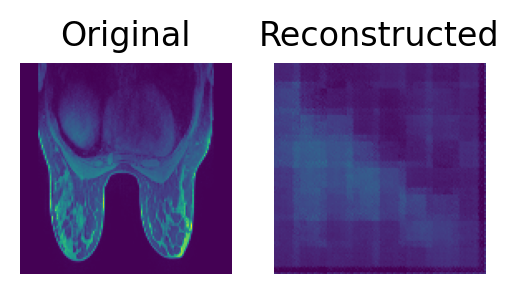

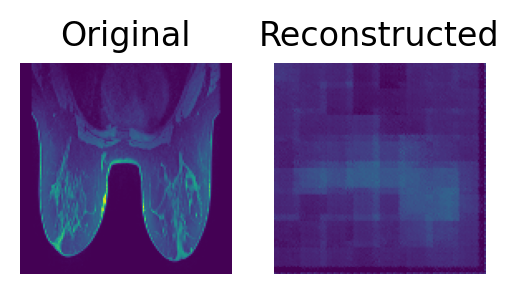

In [ ]:
#L2 loss, minmax [-1,1] data, NO FINAL ACTIVATION FUNCTION
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25]

images = [t1[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

## Generating images

<b>first approach</b>: randomly sample points $\sim N(0,1)$ representing points in the latent space. Since we regularised the latent space to be similiar to a standard normal =using KL divergence, we shoudl *expect it to be similiar*. 

In [ ]:
torch.manual_seed(5) 
points = torch.distributions.Normal(0, 1).sample((16,32,4,4)) #sample 25 points from the latent space
points.shape

generated = vae.decoder(points)
generated.shape

torch.Size([16, 1, 128, 128])

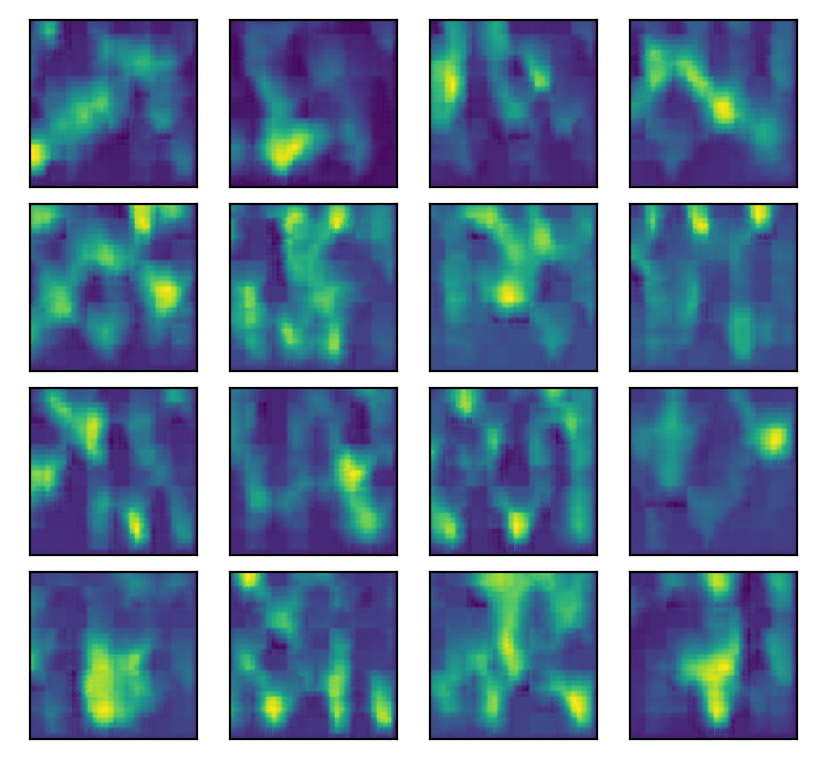

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)

fig.tight_layout()
for i in range(4):    
  for j in range(4): 
    ax[i,j].imshow(generated[i*4 + j][0].detach().numpy())
    plt.xticks([])
    plt.yticks([])
    ax[i,j].set_aspect('equal')
  
fig.subplots_adjust(wspace=-0.6, hspace=0.1)


## Yu's suggestion

However, in reality, the distribution of the images may not be normal, so this sampling method may not generate realistic images. 

Yu's suggestion: augment each batch. Pass the batch through the encoder, get the corresonding points in the latent space. then perturb the points, and decode the perturbed points. 

In [ ]:
def generate_from_batch(t1, vae, prop = 0.25):
  #given t1: tensor, feeds the batch through encoder -> points in latent space
  #prop: what prop of the batch to augment? 
  batch_size = t1.shape[0]

  latent_points = vae.encoder(torch.index_select(t1, 0, torch.tensor(list(range(int(batch_size*prop)))).to(device)))
  torch.manual_seed(1)
  epsilons = torch.distributions.Normal(0, 1/2).sample(latent_points.shape).to(device) #sample normal errors. same size

  new_latent_points = torch.add(latent_points, epsilons)#perturb the points

  new_t1 = vae.decoder(new_latent_points)

  return new_t1

In [ ]:
newpoints = None; oldpoints = None; torch.manual_seed(5) 
for i, (t1, t2, mask) in enumerate(train_loader):
    t1 = t1.to(device); mask = mask.to(device,dtype=torch.float)
    new_t1 = generate_from_batch(t1, vae = vae, prop = 0.0705)
    print(new_t1.shape)

    if i == 0:
      oldpoints = torch.index_select(t1, 0, torch.tensor(list(range(9))).to(device))
      newpoints = new_t1

torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([9, 1, 128, 128])
torch.Size([4, 1, 128, 128])


In [ ]:
print(oldpoints.shape)
newpoints.shape

torch.Size([9, 1, 128, 128])


torch.Size([9, 1, 128, 128])

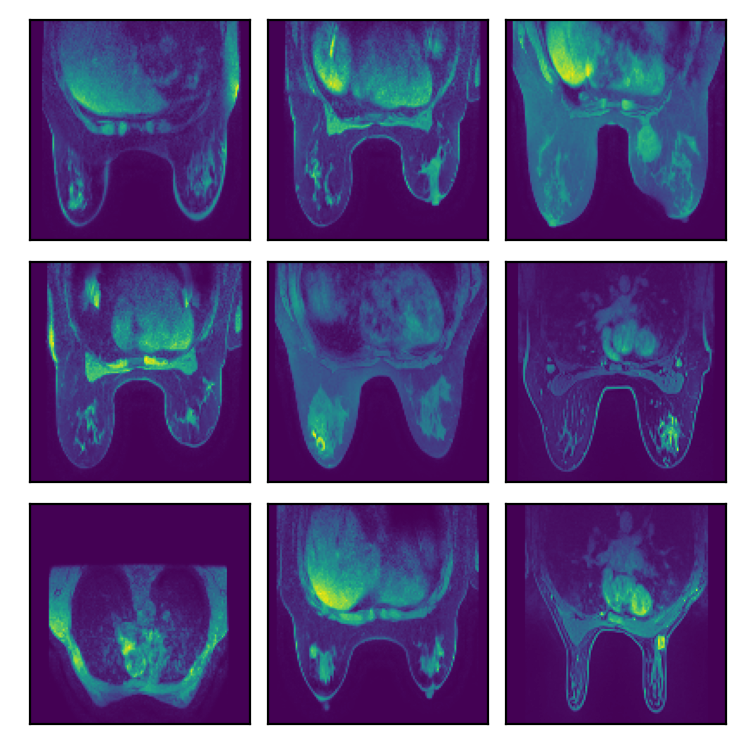

In [ ]:
#original points from the batch
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

fig.tight_layout()
for i in range(3):    
  for j in range(3): 
    ax[i,j].imshow(oldpoints[i*3 + j][0].detach().numpy())
    plt.xticks([])
    plt.yticks([])
    ax[i,j].set_aspect('equal')
  
fig.subplots_adjust(wspace=-0.6, hspace=0.1)

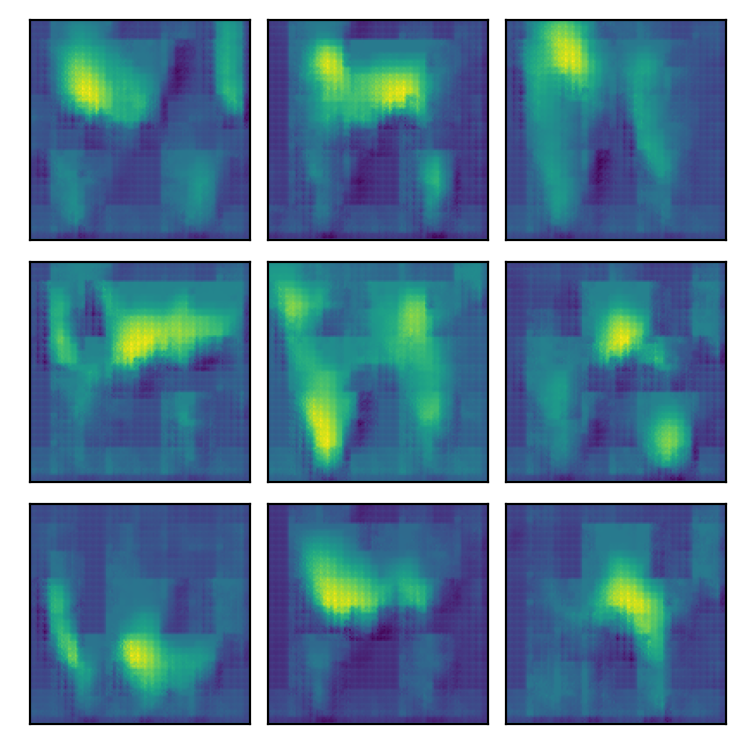

In [ ]:
#augmented images
fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

fig.tight_layout()
for i in range(3):    
  for j in range(3): 
    ax[i,j].imshow(newpoints[i*3 + j][0].detach().numpy())
    plt.xticks([])
    plt.yticks([])
    ax[i,j].set_aspect('equal')
  
fig.subplots_adjust(wspace=-0.6, hspace=0.1)

## Saving models

In [ ]:
# Create a folder called checkpoints if there isn't one
import os

path = '/content/drive/MyDrive/Colab Notebooks/mri_models' + '/vae_T1.pth'
print(path)

# Save parameters
#torch.save(vae.state_dict(), path)

/content/drive/MyDrive/Colab Notebooks/mri_models/vae_T1.pth


In [ ]:
# Instantiate model
vae = VariationalAutoencoder().to(device)

# Load saved parameters
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

## VAE on T2

In [ ]:
#train over epochs of the training set
#loss_fn = nn.L1Loss() #Mean Absoluate Error
#loss_fn = nn.BCELoss()

def train(autoencoder, data, valid_data, epochs=3, lr = 0.003, recon_loss_fn = F.mse_loss):
    early_stopper = EarlyStopper(patience=3, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(autoencoder.parameters(), lr) #default lr = 0.001

    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t1, t2, mask) in enumerate(data):
            t2 = t2.to(device) # GPU
           
            opt.zero_grad()
            t2_hat = autoencoder(t2) #t2 now #(128, 1, 256, 256) for one batch
            reconstruction = recon_loss_fn(t2, t2_hat)#((t1 - t1_hat)**2).mean()
            kl = autoencoder.encoder.kl.mean()
            loss = reconstruction + kl #try MSE.mean(), suggested by Y
            #if custom loss fn, loss_fn(x_hat, x)
            
            print("batch {} loss: {:.5} MSE {:.4}, KL {:.4}".format(i, loss.item(), reconstruction, kl.item()))

            loss.backward()
            opt.step()

             # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t1.shape[0]/num_samples)

      valid_mse, valid_kl = validate_one_epoch(autoencoder, valid_data, recon_loss_fn)
      print("validation loss {:.5} MSE {:.4} KL {:.4}\n".format(valid_mse + valid_kl, valid_mse, valid_kl) )

      table.iloc[epoch, 1] = np.round(train_loss, 3)
      table.iloc[epoch, 2] = np.round((valid_mse + valid_kl).item(), 3)

      if early_stopper.early_stop(valid_mse + valid_kl):             
        break
            
    return autoencoder, table

torch.manual_seed(4) # 3 is a bad seed for mean, std normalised data. used 4
# vae = VariationalAutoencoder(latent_dims = 16).to(device) # train simplest version
vae = VariationalAutoencoder().to(device) 
vae, table = train(vae, train_loader, test_loader, epochs = 60, lr = 0.001, recon_loss_fn = F.mse_loss)

epoch: 0
batch 0 loss: 10.641 MSE 2.014, KL 8.627
batch 1 loss: 5.8652 MSE 1.99, KL 3.875
batch 2 loss: 4.601 MSE 1.971, KL 2.63
batch 3 loss: 3.8357 MSE 1.949, KL 1.887
batch 4 loss: 3.7145 MSE 1.941, KL 1.774
batch 5 loss: 3.5163 MSE 1.923, KL 1.593
batch 6 loss: 3.0532 MSE 1.915, KL 1.138
batch 7 loss: 2.9798 MSE 1.906, KL 1.074
batch 8 loss: 2.7702 MSE 1.895, KL 0.8754
batch 9 loss: 2.7156 MSE 1.881, KL 0.8341
validation loss 2.4323 MSE 0.9924 KL 1.44

epoch: 1
batch 0 loss: 1.5285 MSE 0.9802, KL 0.5483
batch 1 loss: 1.5157 MSE 0.9802, KL 0.5355
batch 2 loss: 1.5068 MSE 0.9754, KL 0.5314
batch 3 loss: 1.4956 MSE 0.9764, KL 0.5191
batch 4 loss: 1.4936 MSE 0.9777, KL 0.5159
batch 5 loss: 1.478 MSE 0.9731, KL 0.5049
batch 6 loss: 1.4724 MSE 0.9745, KL 0.4979
batch 7 loss: 1.4709 MSE 0.9725, KL 0.4984
batch 8 loss: 1.4616 MSE 0.9735, KL 0.4881
batch 9 loss: 1.452 MSE 0.9741, KL 0.4779
validation loss 2.268 MSE 0.9865 KL 1.282

epoch: 2
batch 0 loss: 1.4476 MSE 0.9735, KL 0.4741
batch 1

In [ ]:
torch.manual_seed(3)
(t1, t2, mask)= next(iter(train_loader)) #get one batch
t2 = t2.to(device)
reconstructions = vae(t2)

In [ ]:
def show_subplot(original, reconstructed):
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 2, 1); plt.title("Original"); plt.axis("off")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2); plt.title("Reconstructed"); plt.axis("off")
    plt.imshow(reconstructed.detach(), vmin = torch.min(original), vmax = torch.max(original))
    
    plt.show()

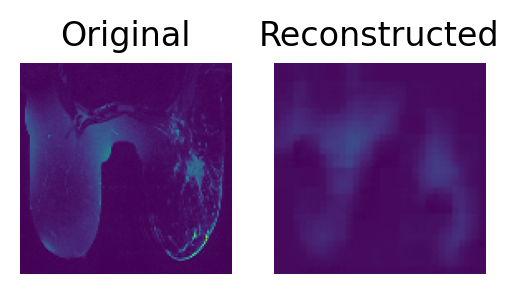

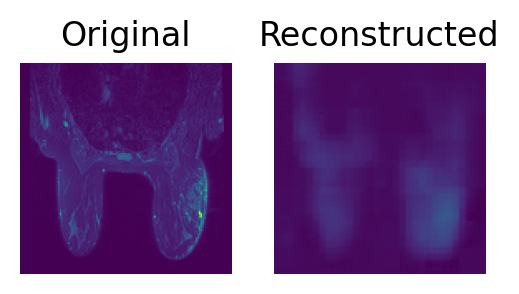

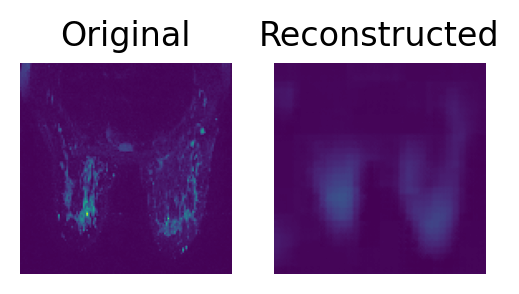

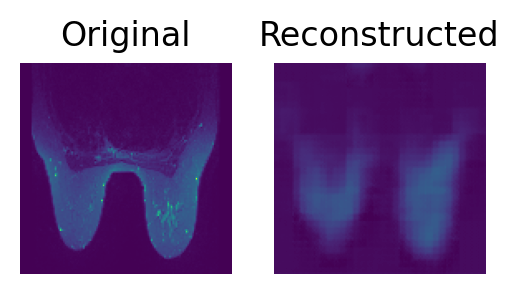

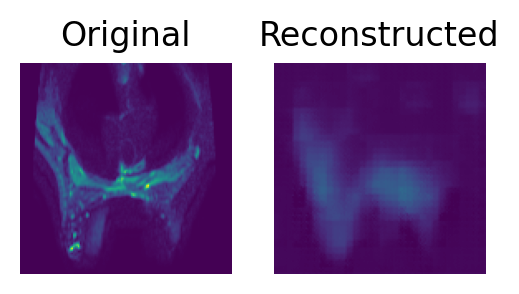

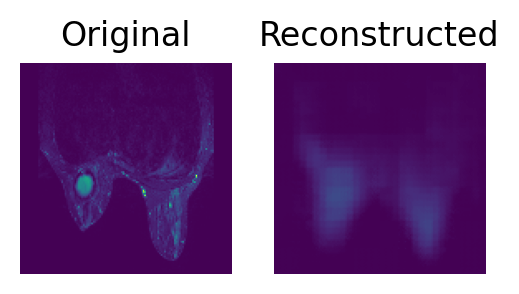

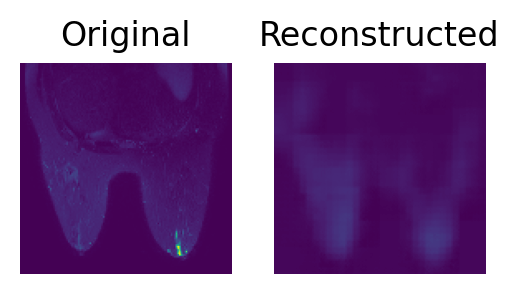

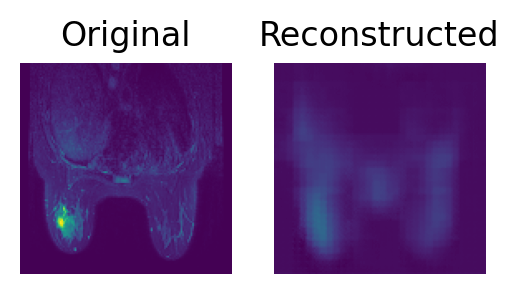

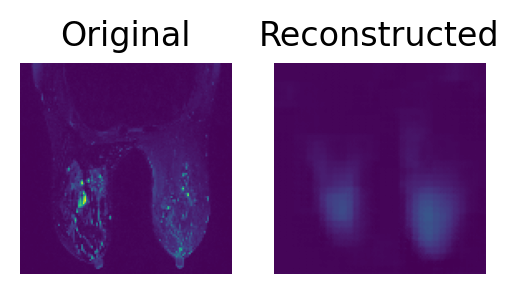

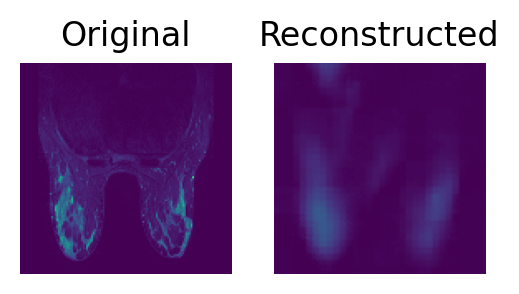

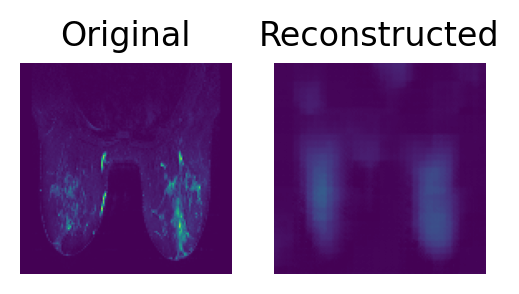

In [ ]:

idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25]

images = [t2[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())
    

## VAE on masks

#### prelims

we redefine the functions, and specify the dice loss

In [23]:
#early stopper https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            print("validation didn't improve")
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [24]:
def validate_one_epoch(autoencoder, loader, recon_loss_fn):
    #validate results on the validation loader
    
    autoencoder.eval()# Set model to evaluation mode
    num_samples = len(loader.dataset) 
    
    mse = 0.0
    kl = 0.0
    
    latent_dim = None
    for i, (t1, t2, mask) in enumerate(loader):

        # Move data to GPU, if available
        t1 = t1.to(device); t2 = t2.to(device); mask = mask.to(device, dtype=torch.float)

        with torch.no_grad():  # sure that we will not backpropagate
            
            if latent_dim is None:
              latent_dim = torch.tensor(autoencoder.encoder(t1).shape)
              
            # Prediction
            mask_hat = autoencoder(mask) #(128, 1, 256, 256) predictions for one batch

            mse += recon_loss_fn(mask_hat, mask)*(t1.shape[0]/num_samples) #e.g MSE takes the mean already
            
            #am I even calculating kl properly?
            kl += autoencoder.encoder.kl.sum()/t1.shape[0] #sum over [128, 128,   5,   5], then divide by batch size. i.e. average TOTAL kl per image

    #mse = mse/(num_samples*256*256) #then average
    kl = kl/(torch.prod(latent_dim[1:]).item())
    return mse, kl

In [25]:
def dice_loss(input, target):
  #input and target are tensors
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [26]:
a = np.array([[1,1,1], [0,0,0]])
target = torch.from_numpy(a)

b = np.array([[1,1,1], [1,1,0]])
input = torch.from_numpy(b)

print(dice_loss(input, target))


tensor(0.2222)


#### architecture

Note: the one difference we make to the mask decoder, is that we append a sigmoid activation layer at the end of the decoder. This is because the masks are binary {0: healthy tissue, 1: tumour}, so we map our model output to [0,1] too. 

Note: we tried out several difference architectures and loss functions. The best approach we found is run below. 

In [ ]:
# #simplest + conv layer to latent
# class VariationalEncoder(nn.Module):
#     def __init__(self):
#         super(VariationalEncoder, self).__init__()

#         self.conv1 = nn.Conv2d(1, 4, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels
#         #at first, 1-8, 8-16, 16-24. smaller bottleneck worked better
#         self.bn1 = nn.BatchNorm2d(4)
#         self.pool = nn.MaxPool2d(2, 2)

#         self.conv2 = nn.Conv2d(4, 8, kernel_size = 3, stride = 2, padding = 1)
#         self.bn2 = nn.BatchNorm2d(8)
        
#         #mean and std
#         self.conv3 = nn.Conv2d(8, 16, kernel_size = 4, stride = 2)
#         self.conv4 = nn.Conv2d(8, 16, kernel_size = 4, stride = 2)

#         self.N = torch.distributions.Normal(0, 1)
#         self.kl = 0

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

#         x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

#         mu =  self.conv3(x)
#         sigma = torch.exp(self.conv4(x)) #exponential activation to ensure positive
#         z = mu + sigma*self.N.sample(mu.shape)
#         self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
#         return z

In [ ]:
# from torchinfo import summary
# summary(VariationalEncoder(), input_size= mask.shape)

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.convt1 = nn.ConvTranspose2d(16, 8, kernel_size = 4, stride = 2) #kernel_size = 3, stride = 2, padding = 1, output_padding = 1
#         self.bn1 = nn.BatchNorm2d(8)

#         self.convt2 = nn.ConvTranspose2d(8, 4, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
#         self.bn2 = nn.BatchNorm2d(4)

#         self.convt3 = nn.ConvTranspose2d(4, 1, kernel_size = 6,  stride = 4, padding = 1) #undo the maxpool and conv
#         self.bn3 = nn.BatchNorm2d(1)

#     def forward(self, z):
#         z = F.leaky_relu(self.bn1(self.convt1(z)))

#         z = F.leaky_relu(self.bn2(self.convt2(z)))
        
#         logits = self.convt3(z)
#         p = torch.sigmoid(logits) #for when DICE
#         return p



In [ ]:
# summary(Decoder(), input_size= (128, 16, 3, 3) )

In [ ]:
# class VariationalAutoencoder(nn.Module):
#     def __init__(self):
#         super(VariationalAutoencoder, self).__init__()
#         self.encoder = VariationalEncoder()
#         self.decoder = Decoder()

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

In [18]:
#simplest + conv layer to latent
class VariationalEncoder(nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1) #increase the number of channels
        #at first, 1-8, 8-16, 16-24. smaller bottleneck worked better
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)
        
        #mean and std
        self.conv3 = nn.Conv2d(16, 24, kernel_size = 4, stride = 2)
        self.conv4 = nn.Conv2d(16, 24, kernel_size = 4, stride = 2)

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x))); x = self.pool(x)

        x = F.leaky_relu(self.bn2(self.conv2(x))); x = self.pool(x)

        mu =  self.conv3(x)
        sigma = torch.exp(self.conv4(x)) #exponential activation to ensure positive
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2)
        return z

from torchinfo import summary
summary(VariationalEncoder(), input_size= mask.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VariationalEncoder                       [128, 24, 3, 3]           --
├─Conv2d: 1-1                            [128, 8, 64, 64]          80
├─BatchNorm2d: 1-2                       [128, 8, 64, 64]          16
├─MaxPool2d: 1-3                         [128, 8, 32, 32]          --
├─Conv2d: 1-4                            [128, 16, 16, 16]         1,168
├─BatchNorm2d: 1-5                       [128, 16, 16, 16]         32
├─MaxPool2d: 1-6                         [128, 16, 8, 8]           --
├─Conv2d: 1-7                            [128, 24, 3, 3]           6,168
├─Conv2d: 1-8                            [128, 24, 3, 3]           6,168
Total params: 13,632
Trainable params: 13,632
Non-trainable params: 0
Total mult-adds (M): 94.43
Input size (MB): 8.39
Forward/backward pass size (MB): 75.94
Params size (MB): 0.05
Estimated Total Size (MB): 84.38

In [19]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = nn.ConvTranspose2d(24, 16, kernel_size = 4, stride = 2) #kernel_size = 3, stride = 2, padding = 1, output_padding = 1
        self.bn1 = nn.BatchNorm2d(16)

        self.convt2 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 4, padding = 1,  output_padding = 1)
        self.bn2 = nn.BatchNorm2d(8)

        self.convt3 = nn.ConvTranspose2d(8, 1, kernel_size = 6,  stride = 4, padding = 1) #undo the maxpool and conv
        #self.bn3 = nn.BatchNorm2d(1)

        #self.conv = nn.Conv2d(1,1, kernel_size = 3, padding = 1)

    def forward(self, z):
        z = F.leaky_relu(self.bn1(self.convt1(z)))

        z = F.leaky_relu(self.bn2(self.convt2(z)))

        #z = F.leaky_relu(self.bn3(self.convt3(z)))
        
        logits = self.convt3(z)
        p = torch.sigmoid(logits) #for when DICE
        return p

In [20]:
summary(Decoder(), input_size= (128, 24, 3, 3) )

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [128, 1, 128, 128]        --
├─ConvTranspose2d: 1-1                   [128, 16, 8, 8]           6,160
├─BatchNorm2d: 1-2                       [128, 16, 8, 8]           32
├─ConvTranspose2d: 1-3                   [128, 8, 32, 32]          3,208
├─BatchNorm2d: 1-4                       [128, 8, 32, 32]          16
├─ConvTranspose2d: 1-5                   [128, 1, 128, 128]        289
Total params: 9,705
Trainable params: 9,705
Non-trainable params: 0
Total mult-adds (G): 1.08
Input size (MB): 0.11
Forward/backward pass size (MB): 35.65
Params size (MB): 0.04
Estimated Total Size (MB): 35.80

In [21]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### train

In [27]:
#train over epochs of the training set

def train(autoencoder, data, valid_data, epochs=3, lr = 0.003, recon_loss_fn = F.mse_loss):
    early_stopper = EarlyStopper(patience=4, min_delta = 0.0) # if validation loss > min validation loss + min_delta, start counting

    opt = torch.optim.Adam(autoencoder.parameters(), lr) #default lr = 0.001

    # Initialise table to track training
    num_samples = len(data.dataset)
    table = pd.DataFrame(np.arange(1, epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0

    for epoch in range(epochs):
      print("epoch:", epoch)
      train_loss = 0.0

      for i, (t1, t2, mask) in enumerate(data):
            mask = mask.to(device, dtype=torch.float)
           
            opt.zero_grad()
            mask_hat = autoencoder(mask) 
            reconstruction = recon_loss_fn(input = mask_hat, target = mask) 
            #input (Tensor) – Tensor with unnormalized scores (often referred to as logits).
            #target (Tensor) – Tensor of the same shape as input with values between 0 and 1

            kl = autoencoder.encoder.kl.mean()
            loss = reconstruction + kl 
            
            print("batch {} loss: {:.5} DICE {:.4}, KL {:.4}".format(i, loss.item(), reconstruction, kl.item()))

            loss.backward()
            opt.step()

           # Training set metrics   
            with torch.no_grad(): 
                
                l = loss.cpu().detach().numpy()
                train_loss +=  l*(t1.shape[0]/num_samples)

      valid_mse, valid_kl = validate_one_epoch(autoencoder, valid_data, recon_loss_fn)
      print("validation loss {:.5} DICE {:.4} KL {:.4}\n".format(valid_mse + valid_kl, valid_mse, valid_kl) )

      table.iloc[epoch, 1] = np.round(train_loss, 3)
      table.iloc[epoch, 2] = np.round((valid_mse + valid_kl).item(), 3)

      if early_stopper.early_stop(valid_mse):          # ONLY LOOK AT DICE FOR EARLY STOPPING  
        break
            
    return autoencoder, table

torch.manual_seed(4) 
vae = VariationalAutoencoder().to(device) 
vae, table = train(vae, train_loader, test_loader, epochs = 50, lr = 0.02, recon_loss_fn = dice_loss) #dice_loss (use torch.sigmoid in Decoder). Or F.binary_cross_entropy_with_logits

#using the best VAE for T1 and T2
#if our loss is binary cross entropy, loss gets minimised A LOT: validation at start 0.7104 down to 0.02 at the end. But images look real bad
#dice loss doesn't get minimised

#using the simple MNIST VAE
#BCE also looks promising (although bad)
#dice loss goes down (very slow)

#using simple VAE + convolutional map to latent space. Takes a few epochs for dice score to decrease 

epoch: 0
batch 0 loss: 461.97 DICE 0.9966, KL 461.0
batch 1 loss: 3.1021 DICE 0.9966, KL 2.106
batch 2 loss: 2.5337 DICE 0.996, KL 1.538
batch 3 loss: 2.7113 DICE 0.995, KL 1.716
batch 4 loss: 2.7525 DICE 0.9957, KL 1.757
batch 5 loss: 2.9293 DICE 0.9949, KL 1.934
batch 6 loss: 2.9337 DICE 0.995, KL 1.939
batch 7 loss: 2.9834 DICE 0.9949, KL 1.989
batch 8 loss: 3.0005 DICE 0.9964, KL 2.004
batch 9 loss: 2.9823 DICE 0.9966, KL 1.986
validation loss 2.1958 DICE 0.9957 KL 1.2

epoch: 1
batch 0 loss: 1.3872 DICE 0.9961, KL 0.3911
batch 1 loss: 1.3872 DICE 0.9974, KL 0.3897
batch 2 loss: 1.3992 DICE 0.9966, KL 0.4026
batch 3 loss: 1.4043 DICE 0.9963, KL 0.408
batch 4 loss: 1.3959 DICE 0.9968, KL 0.3991
batch 5 loss: 1.4151 DICE 0.9954, KL 0.4197
batch 6 loss: 1.4094 DICE 0.9965, KL 0.4129
batch 7 loss: 1.4052 DICE 0.9966, KL 0.4086
batch 8 loss: 1.4069 DICE 0.997, KL 0.4099
batch 9 loss: 1.407 DICE 0.9973, KL 0.4097
validation loss 2.3041 DICE 0.9951 KL 1.309

epoch: 2
batch 0 loss: 1.4235 

In [28]:
torch.manual_seed(3)
(t1, t2, mask)= next(iter(train_loader)) #get one batch
mask = mask.to(device, dtype=torch.float)
reconstructions = vae(mask) # when using Dice, output is probabilities

In [29]:
def show_subplot(original, reconstructed):
    plt.figure(figsize=(3, 3))
    plt.subplot(1, 2, 1); plt.title("Original"); plt.axis("off")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2); plt.title("Reconstructed"); plt.axis("off")
    plt.imshow(reconstructed.detach(), vmin = torch.min(original), vmax = torch.max(original)) #
    
    plt.show()

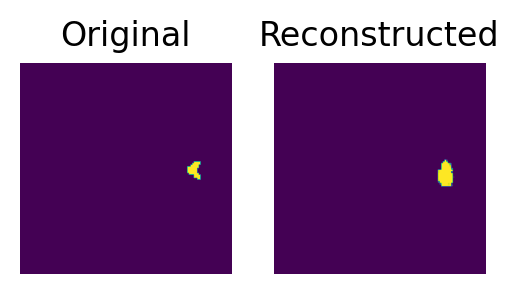

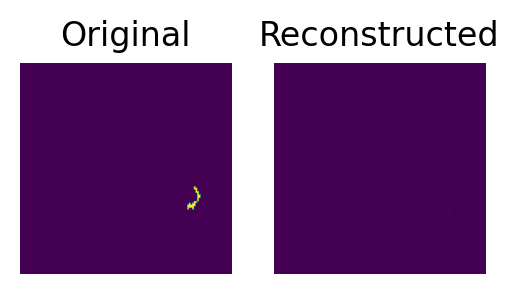

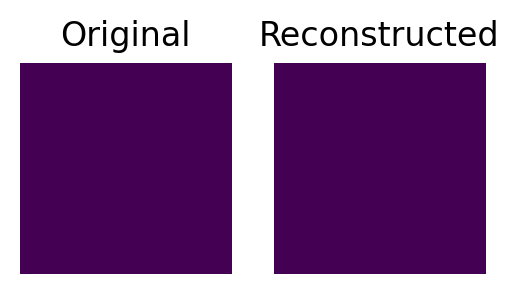

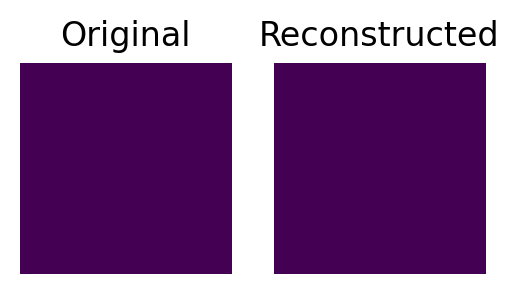

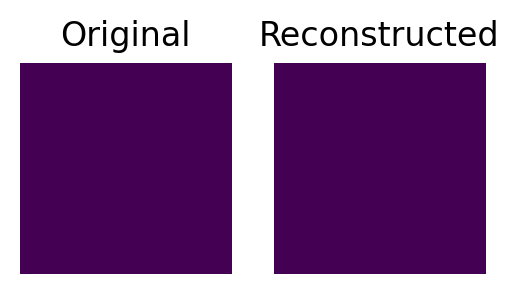

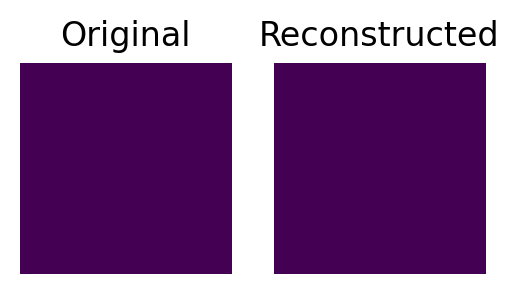

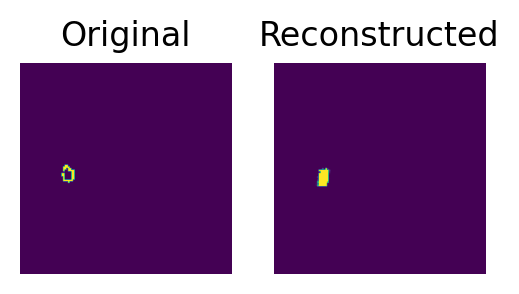

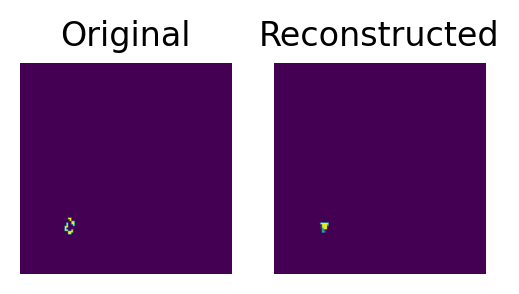

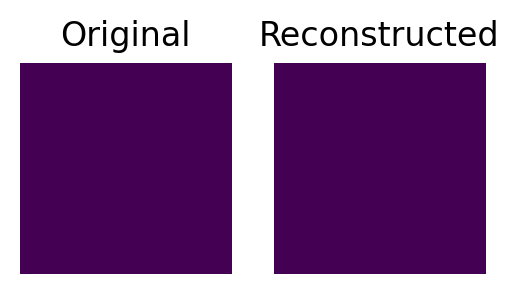

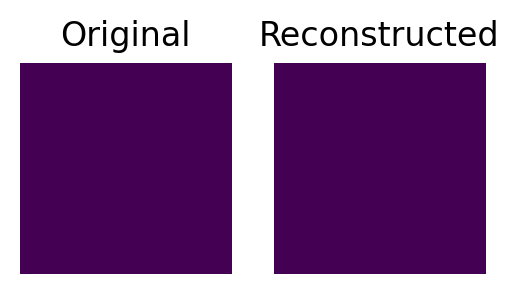

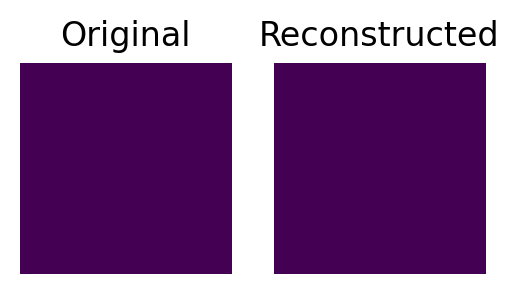

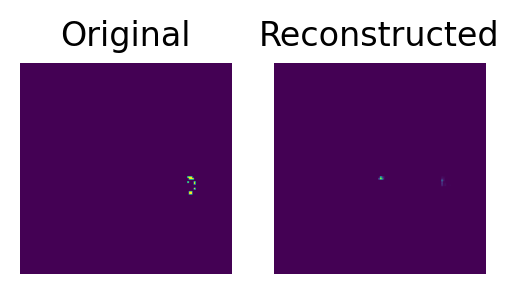

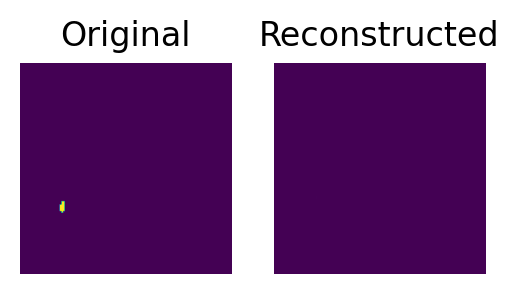

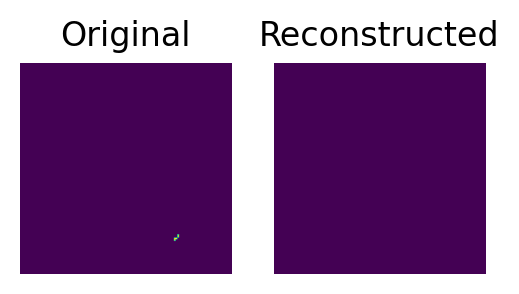

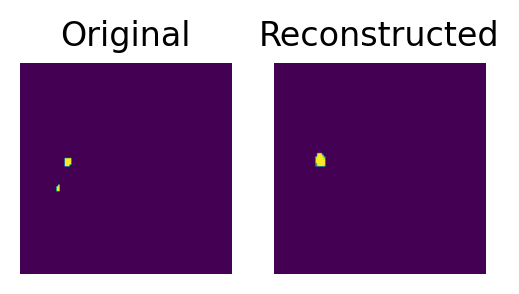

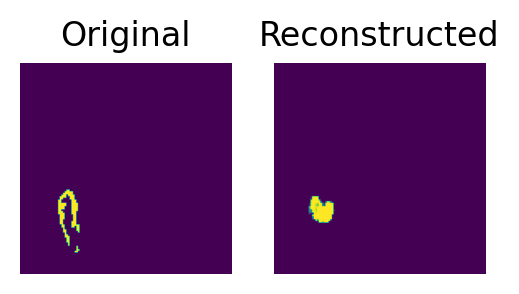

In [30]:
#with convolutional map to latent space (PLAY AROUND). Final validation DICE score of 0.3847, the best!
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25, 30, 31, 32, 34, 35]

images = [mask[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

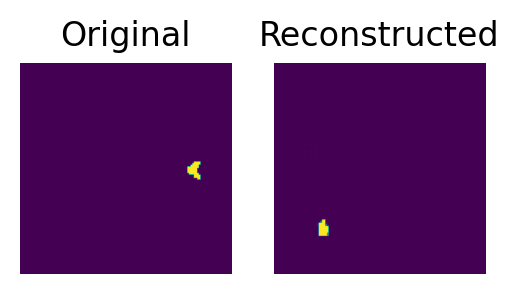

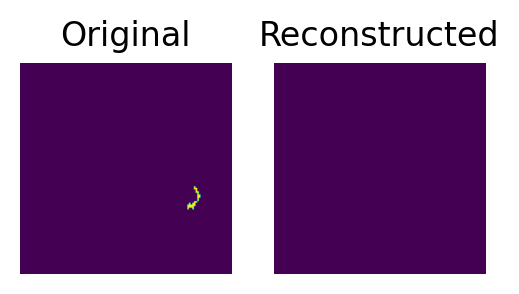

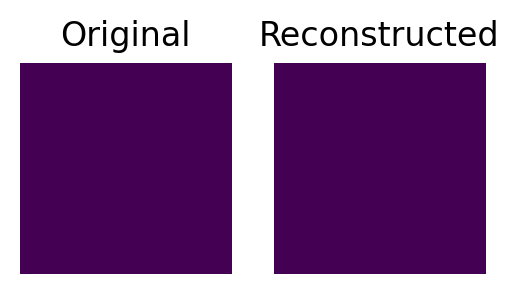

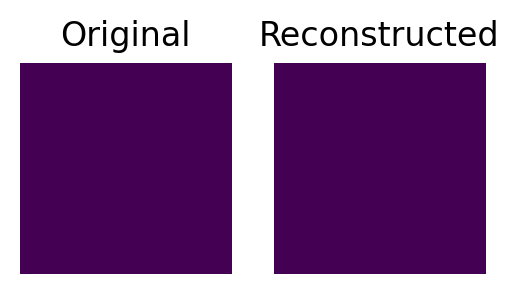

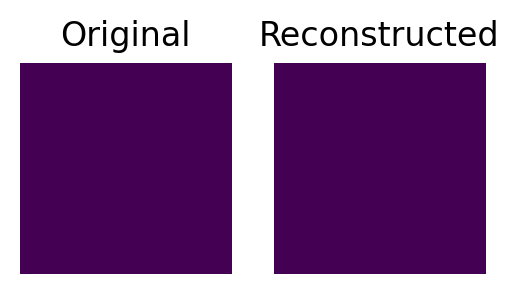

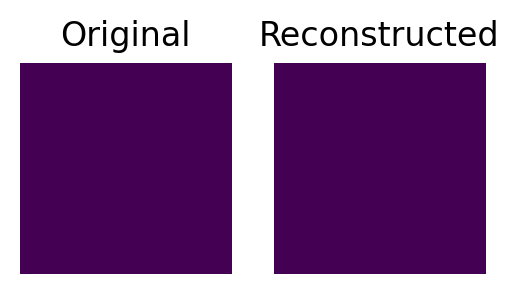

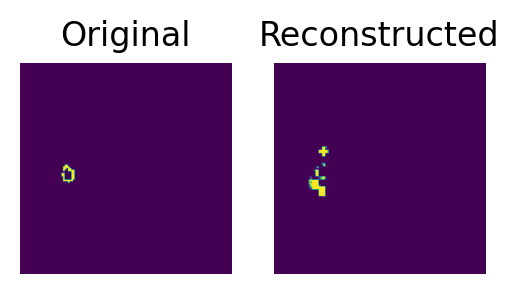

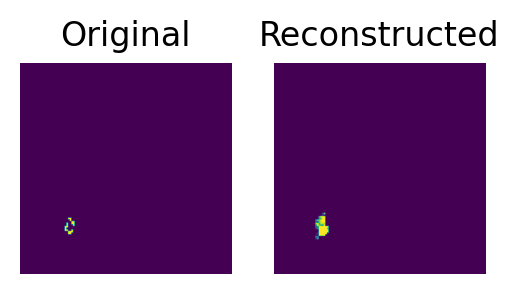

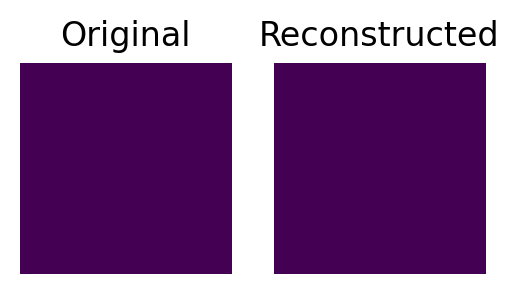

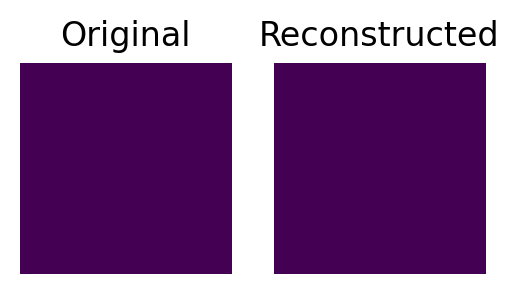

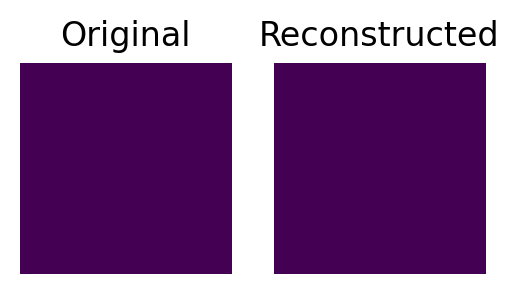

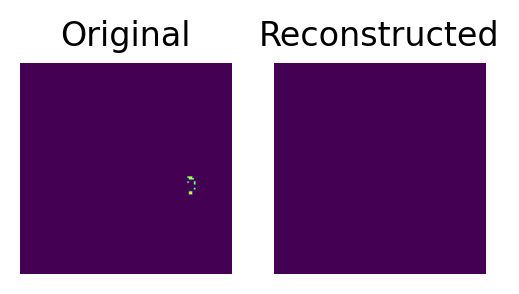

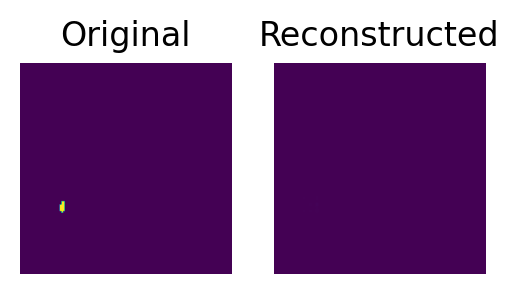

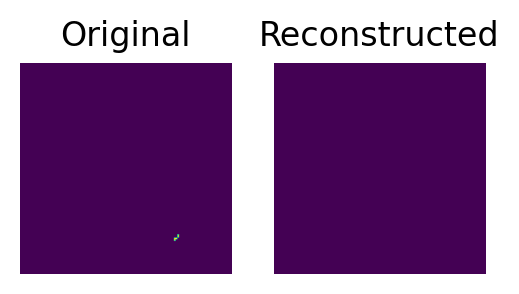

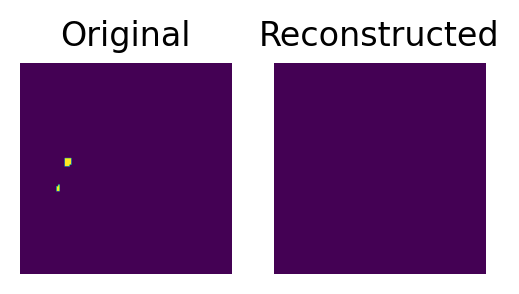

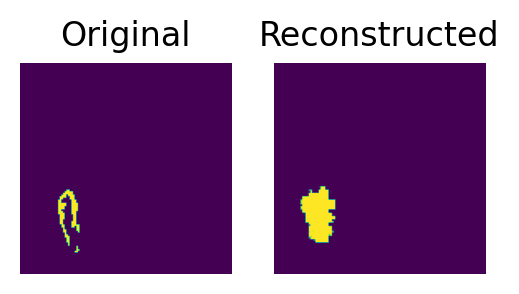

In [ ]:
#with convolutional map to latent space (TIGHTER BOTTLENECK). Final validation DICE score of 0.5754, 
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25, 30, 31, 32, 34, 35]

images = [mask[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

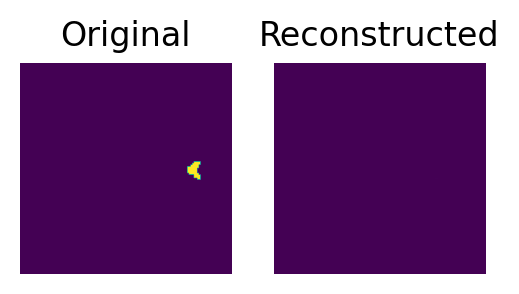

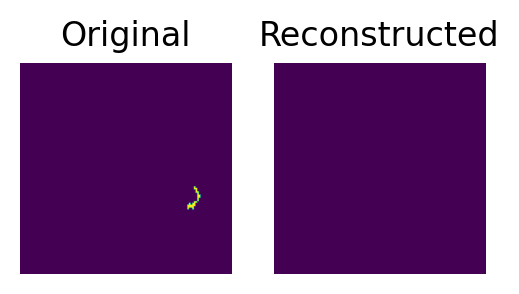

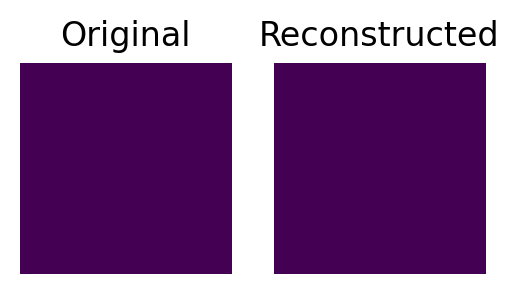

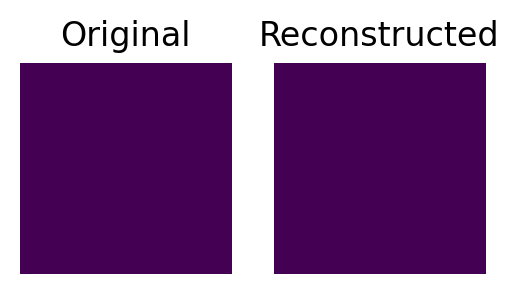

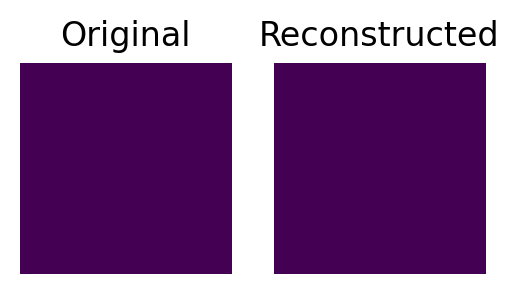

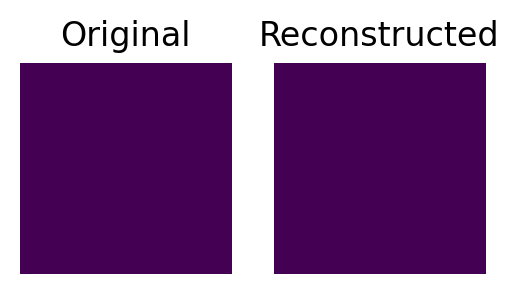

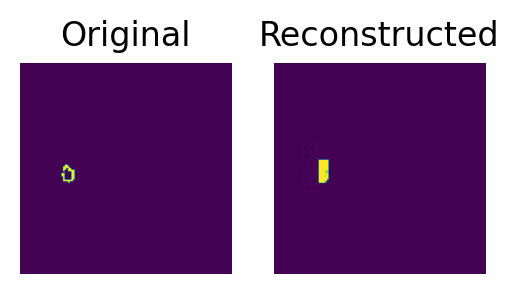

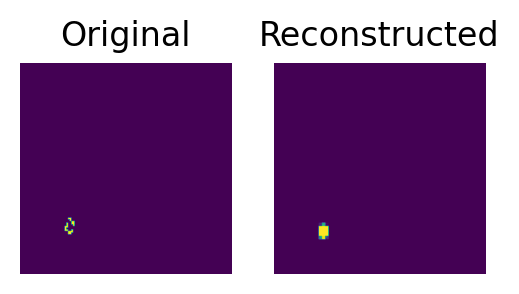

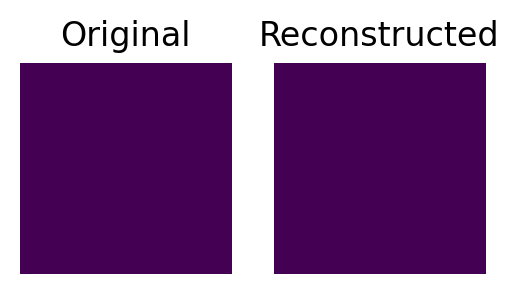

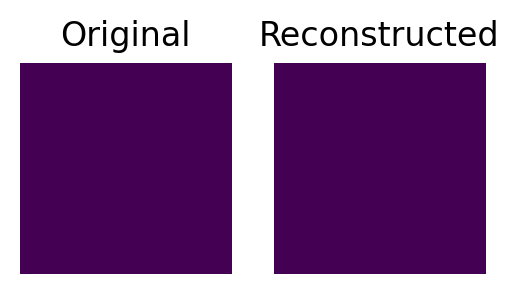

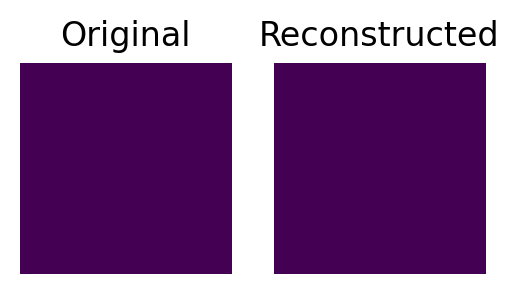

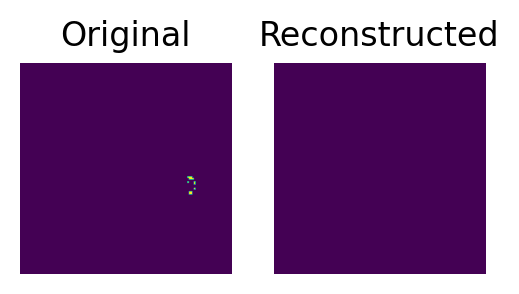

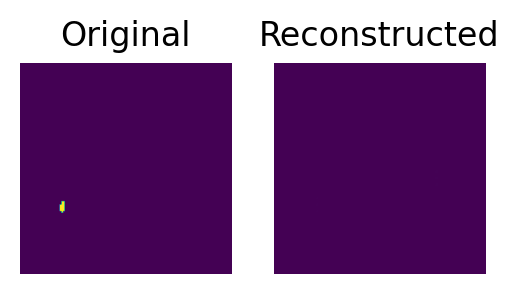

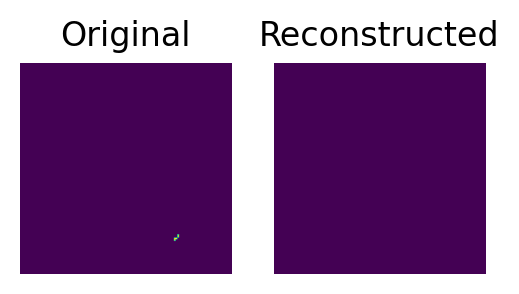

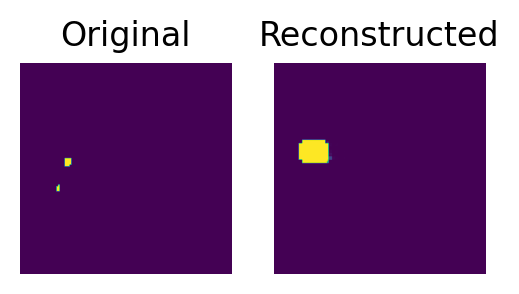

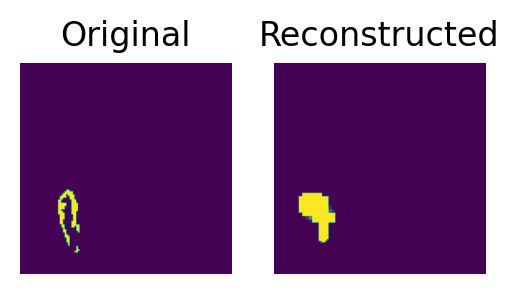

In [ ]:
#with convolutional map to latent space. Final validation DICE score of 0.6164, 
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25, 30, 31, 32, 34, 35]

images = [mask[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())

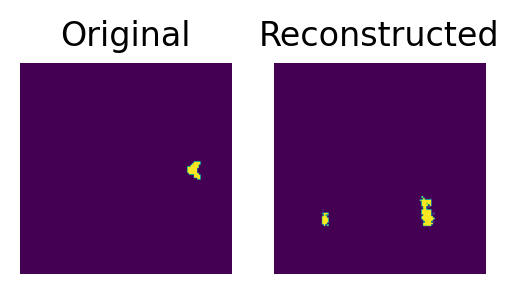

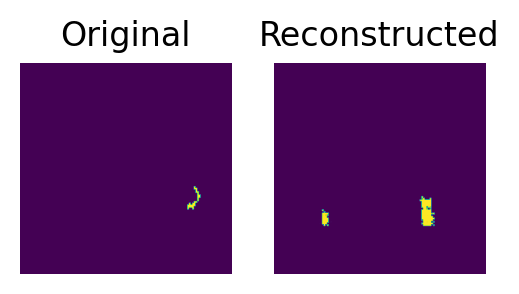

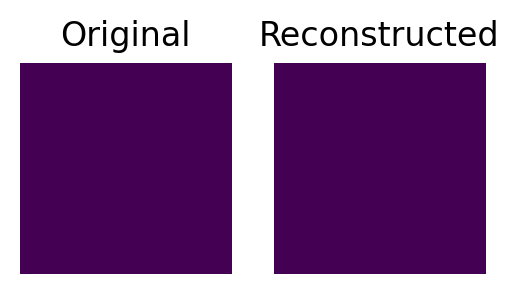

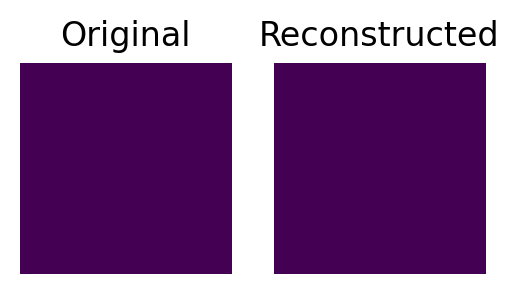

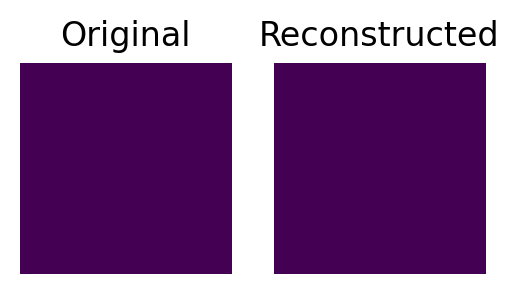

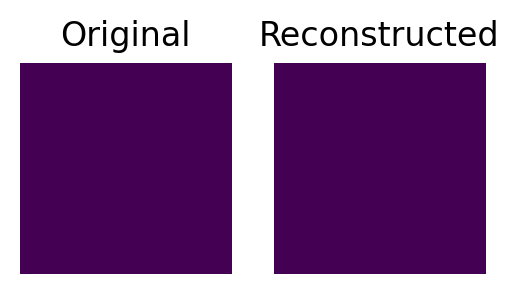

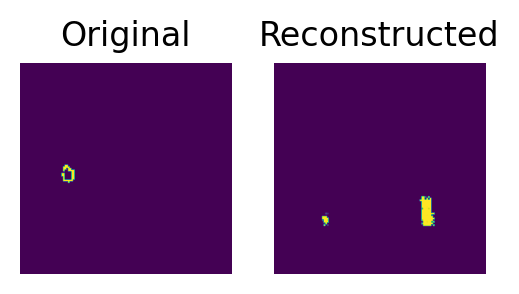

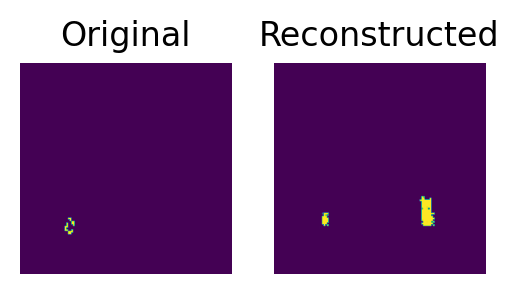

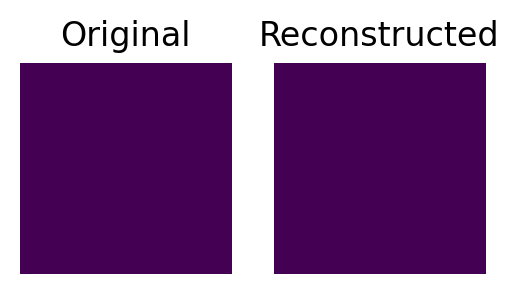

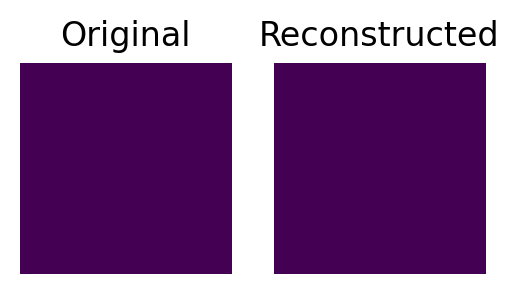

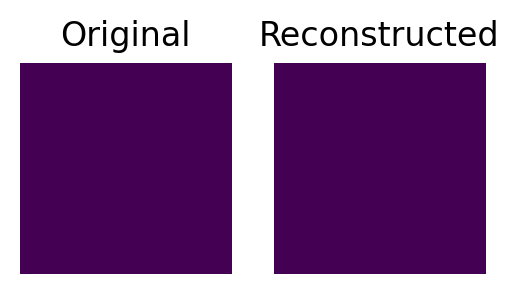

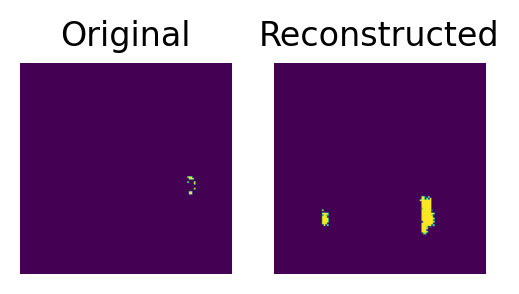

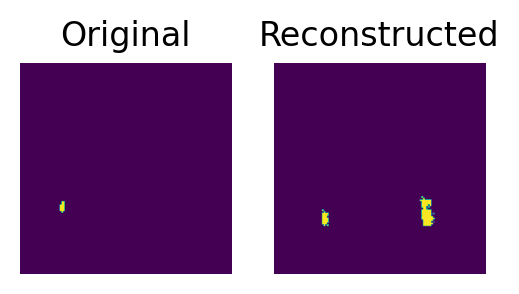

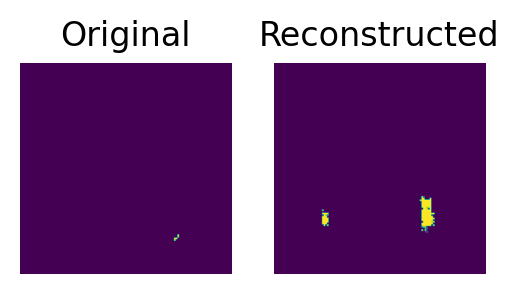

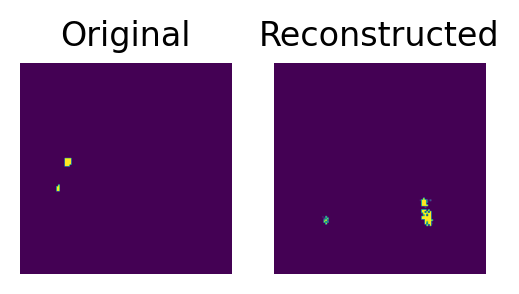

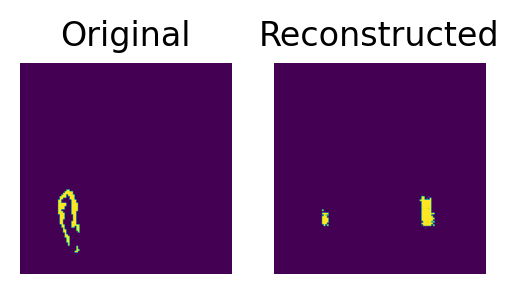

In [ ]:
#with the simplest model, fully connected layers to latent space
idx = [1,4,5,7,9, 12, 15, 17, 20, 22, 25, 30, 31, 32, 34, 35]

images = [mask[id][0] for id in idx]
image_hats = [reconstructions[id][0] for id in idx]

for image, imageh in zip(images, image_hats):
    show_subplot(image.cpu(), imageh.cpu())